# House Price Prediction - Using Advanced Regression

There are many times we are faced with the predicament of finalizing the price of the 'Dream House', situated in a particular neighbourhood. The following notebook tries to de-mystify this relationship between the price and the neighbood to whihc it belongs, by using advanced regression techniques. 

We should be able to answer the following question: **Can the knowledge of the neighborhood enable us to make better prediction of the House Price?**

We make use of the Ames Housing Dataset that is specific to houses in Iowa State, USA. With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this is comprehensive enough for us to predict the final price of each home. 

### Loading Datasets Including Essential libraries

In [135]:
require(ggplot2) # for data visualization
require(stringr) #extracting string patterns
require(Matrix) # matrix transformations
require(glmnet) # ridge, lasso & elastinet
require(xgboost) # gbm
require(randomForest)
require(Metrics) # rmse
require(dplyr) # load this in last so plyr doens't overlap it
require(caret) # one hot encoding
require(scales) # plotting $$
require(e1071) # skewness
require(corrplot) # correlation plot
BLUE='blue'
RED='red'
COLOUR=BLUE

Loading required package: xgboost
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘xgboost’”Loading required package: Metrics
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘Metrics’”Loading required package: e1071
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘e1071’”

The first thing we’ll do is load in the training and testing data. The training data consists of 1460 rows
and 81 columns while the testing has 1459 rows and 80 columns (excluding the SalePrice column),
which in this dataset is the dependent variable we are trying to predict. For us to perform analysis at a
more productive rate we can combine the 2 dataframes together and run analysis on both data sets at
once, then split the data once we are ready to train a model. 

The Id feature is useless so we can toss it out of our dataset and we won’t include SalePrice
since it is our response variable. We also won’t import string variables as factors since our ultimate
goal is to tranform all our variables to numeric.

In [136]:
house.price.train <- read.csv('./data/train.csv', stringsAsFactors = FALSE)
house.price.test <- read.csv('./data/test.csv', stringsAsFactors = FALSE)

In [137]:
house.price.combined <- rbind(within(house.price.train, rm('Id','SalePrice')), within(house.price.test, rm('Id')))
dim(house.price.combined)

[1] 2919   79

We need to look for missing values as they can hamper the performance of the prediction model that we would employ. For each NA column, we need to come up with a reasonable imputation method.

In [138]:
na.cols <- which(colSums(is.na(house.price.combined)) > 0)
sort(colSums(sapply(house.price.combined[na.cols], is.na)), decreasing = TRUE)

PoolQC  MiscFeature        Alley        Fence  FireplaceQu  LotFrontage 
        2909         2814         2721         2348         1420          486 
 GarageYrBlt GarageFinish   GarageQual   GarageCond   GarageType     BsmtCond 
         159          159          159          159          157           82 
BsmtExposure     BsmtQual BsmtFinType2 BsmtFinType1   MasVnrType   MasVnrArea 
          82           81           80           79           24           23 
    MSZoning    Utilities BsmtFullBath BsmtHalfBath   Functional  Exterior1st 
           4            2            2            2            2            1 
 Exterior2nd   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF   Electrical 
           1            1            1            1            1            1 
 KitchenQual   GarageCars   GarageArea     SaleType 
           1            1            1            1

In [139]:
sort(colSums(sapply(house.price.train[na.cols], is.na)), decreasing = TRUE)

PoolQC        Fence  FireplaceQu   GarageType  GarageYrBlt GarageFinish 
        1453         1179          690           81           81           81 
  GarageQual BsmtExposure BsmtFinType2     BsmtQual     BsmtCond BsmtFinType1 
          81           38           38           37           37           37 
  MasVnrType   MSSubClass     MSZoning       Street  LandContour     RoofMatl 
           8            0            0            0            0            0 
 Exterior1st  Exterior2nd   Foundation   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF 
           0            0            0            0            0            0 
  CentralAir    GrLivArea BsmtFullBath KitchenAbvGr TotRmsAbvGrd   Fireplaces 
           0            0            0            0            0            0 
  GarageCars   GarageArea     PoolArea       YrSold 
           0            0            0            0

We can see that there are some common missing value columns in both train and the test datasets. Also, there are certain columns that have missing values only in the test dataset. Essentially, we have a situation where there are many missing value columns in the test data set. We also plot the sample dataframe of train and test data set

### Data Sets: First Look 

In [140]:
paste('The dimensions of the Training Dataset is', dim(house.price.train)[1], 'rows')
paste('The dimensions of the Training Dataset is', dim(house.price.train)[2], 'columns')
paste('The dimensions of the Testing Dataset is', dim(house.price.test)[1], 'rows')
paste('The dimensions of the Testing Dataset is', dim(house.price.test)[2], 'columns')
paste('There are', length(na.cols), 'columns in both train and test dataset combined with missing values')

[1] "The dimensions of the Training Dataset is 1460 rows"

[1] "The dimensions of the Training Dataset is 81 columns"

[1] "The dimensions of the Testing Dataset is 1459 rows"

[1] "The dimensions of the Testing Dataset is 80 columns"

[1] "There are 34 columns in both train and test dataset combined with missing values"

### Sample Train Data Set

In [141]:
head(house.price.train)

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,⋯,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,12,2008,WD,Normal,250000
6,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000


### Sample Test Data Set

In [142]:
head(house.price.test)

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,⋯,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1461,20,RH,80,11622,Pave,NA,Reg,Lvl,AllPub,⋯,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal
1462,20,RL,81,14267,Pave,NA,IR1,Lvl,AllPub,⋯,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74,13830,Pave,NA,IR1,Lvl,AllPub,⋯,0,0,NA,MnPrv,NA,0,3,2010,WD,Normal
1464,60,RL,78,9978,Pave,NA,IR1,Lvl,AllPub,⋯,0,0,NA,NA,NA,0,6,2010,WD,Normal
1465,120,RL,43,5005,Pave,NA,IR1,HLS,AllPub,⋯,144,0,NA,NA,NA,0,1,2010,WD,Normal
1466,60,RL,75,10000,Pave,NA,IR1,Lvl,AllPub,⋯,0,0,NA,NA,NA,0,4,2010,WD,Normal


### Sample Combined Data Set

In [143]:
head(house.price.combined)

MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,⋯,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,⋯,0,0,NA,NA,NA,0,2,2008,WD,Normal
20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,⋯,0,0,NA,NA,NA,0,5,2007,WD,Normal
60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,⋯,0,0,NA,NA,NA,0,9,2008,WD,Normal
70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,⋯,0,0,NA,NA,NA,0,2,2006,WD,Abnorml
60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,⋯,0,0,NA,NA,NA,0,12,2008,WD,Normal
50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,Inside,⋯,0,0,NA,MnPrv,Shed,700,10,2009,WD,Normal


The missing values belonging to a particular column in the training dataset seems to have a pattern. They can be clustered as follows:

1. Parameters belonging to Basement (BsmtExposure, BsmtFinType2, BsmtQual, BsmtCond, BsmtFinType1, etc.)
2. Parameters belonging to Garage (GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond, etc.)
3. Finishing of the house ( MasVnrType, MasVnrArea, etc.)
4. Miscelleneous Features of the House (MiscFeature, Alley, Fence. FireplaceQu, PoolQC, Electrical, etc.)
In all there are 34 missing value columns that needs imputation.

### Static Value Imputation: Function

We create a function that would be useful for replacing NAs with a common value. This would be helpful for static imputation.

In [144]:
impute_NA<-function(df, column, value)
{
    df[is.na(df[column]),column]<-value
    df[is.na(df[column]),c('Id',column)]
    return(df)
}

### Plotting Categorical Column: Function

In [145]:
plot.categoric <- function(cols, df)
{
    for (col in cols) 
    {
        order.cols <- names(sort(table(house.price.combined[,col]), decreasing = TRUE))
        num.plot <- qplot(df[,col]) +
        geom_bar(fill = COLOUR) +
        geom_text(aes(label = ..count..), stat='count', vjust=-0.5) +
        theme_minimal() + scale_y_continuous(limits = c(0,max(table(df[,col]))*1.2)) +
        scale_x_discrete(limits = order.cols) +
        xlab(col) +
        theme(axis.text.x = element_text(angle = 30, size=12))
        print(num.plot)
    }
}

### Handling Missing Values :Function getNA

In [146]:
getNA<-function (df.combined=house.price.combined)
{ 
    na.cols <- which(colSums(is.na(df.combined)) > 0)
    sort(colSums(sapply(df.combined[na.cols], is.na)), decreasing = TRUE)
}

### Handling Missing Values :Miscelleneous features

#### PoolQC

We would have to see whether the PoolQC is missing along with the PoolArea feature. It would natural for the 2 features to have a value simultaneously. If not, it could point to a case where there are no pools at all. There are many records which have PoolQC as NAs, also do not have a PoolArea. There are just 10 records that have PoolQC. We use the mean value (PoolArea) of the particular group, to fill the missing values in PoolQC.

Warning message:
“Removed 2909 rows containing non-finite values (stat_count).”Warning message:
“Removed 2909 rows containing non-finite values (stat_count).”Warning message:
“Removed 2909 rows containing non-finite values (stat_count).”

,PoolQC,PoolArea
2421,NA,368
2504,NA,444
2600,NA,561


PoolQC,mean,counts
Ex,359.7500000,4
Fa,583.5000000,2
Gd,648.5000000,4
NA,0.4719835,2909


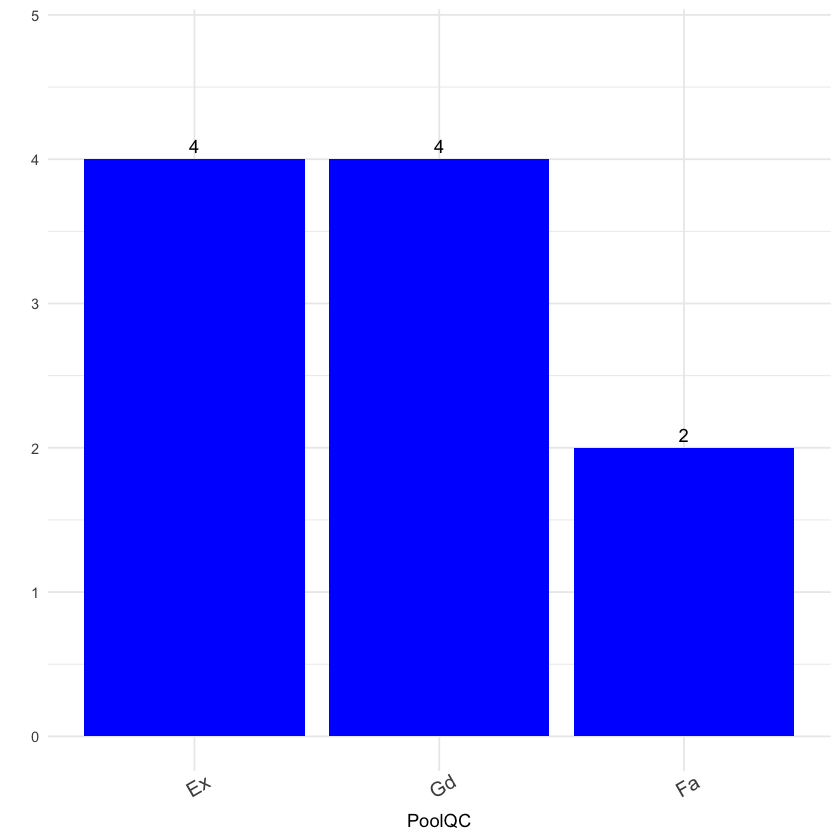

In [147]:
plot.categoric('PoolQC', house.price.combined)
house.price.combined[(house.price.combined$PoolArea > 0) & is.na(house.price.combined$PoolQC),c('PoolQC','PoolArea')]
house.price.combined[,c('PoolQC','PoolArea')] %>%
group_by(PoolQC) %>%
summarise(mean = mean(PoolArea), counts = n())

We can see that most NA's do not have a PoolArea and for those that have one, we use the label that is closest to its PoolArea.

In [148]:
house.price.combined[2421,'PoolQC'] = 'Ex'
house.price.combined[2504,'PoolQC'] = 'Ex'
house.price.combined[2600,'PoolQC'] = 'Fa'
house.price.combined$PoolQC[is.na(house.price.combined$PoolQC)] = 'None'

#### KitchenQual & Electrical

With only 1 missing value for KitchenQual and Electrical each we can fill in the missing value with the most frequent value from each column. The most common value for KitchenQual is 'TA' and that for Electrical is 'SBrkr'.

Warning message:
“Removed 1 rows containing non-finite values (stat_count).”Warning message:
“Removed 1 rows containing non-finite values (stat_count).”Warning message:
“Removed 1 rows containing non-finite values (stat_count).”Warning message:
“Removed 1 rows containing non-finite values (stat_count).”Warning message:
“Removed 1 rows containing non-finite values (stat_count).”Warning message:
“Removed 1 rows containing non-finite values (stat_count).”

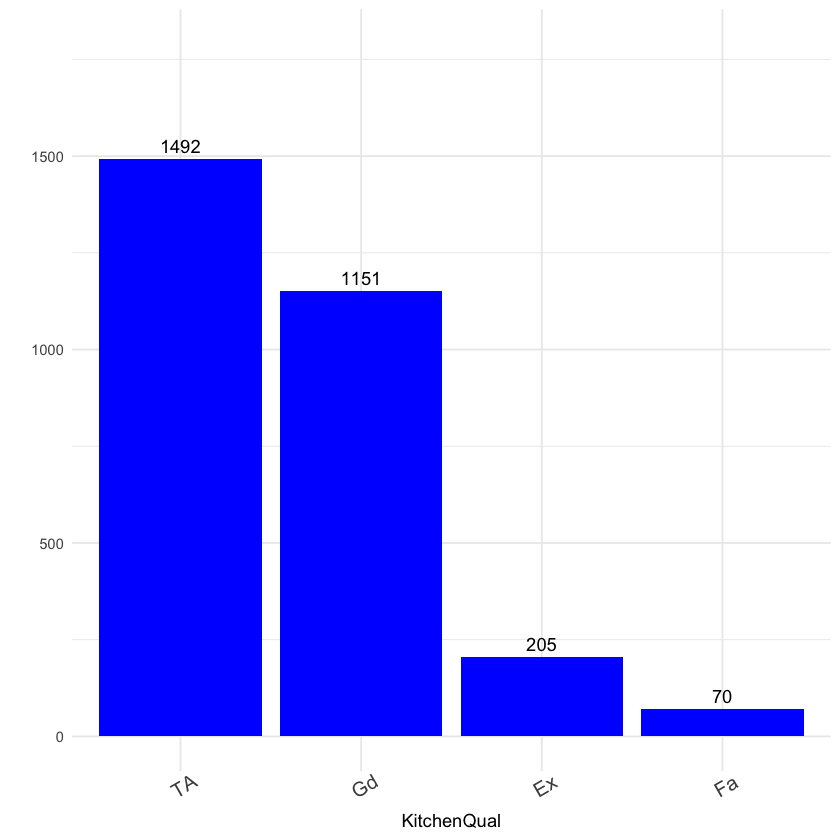

[1] "There are 0 missing values left"

[1] "There are 0 missing values left"

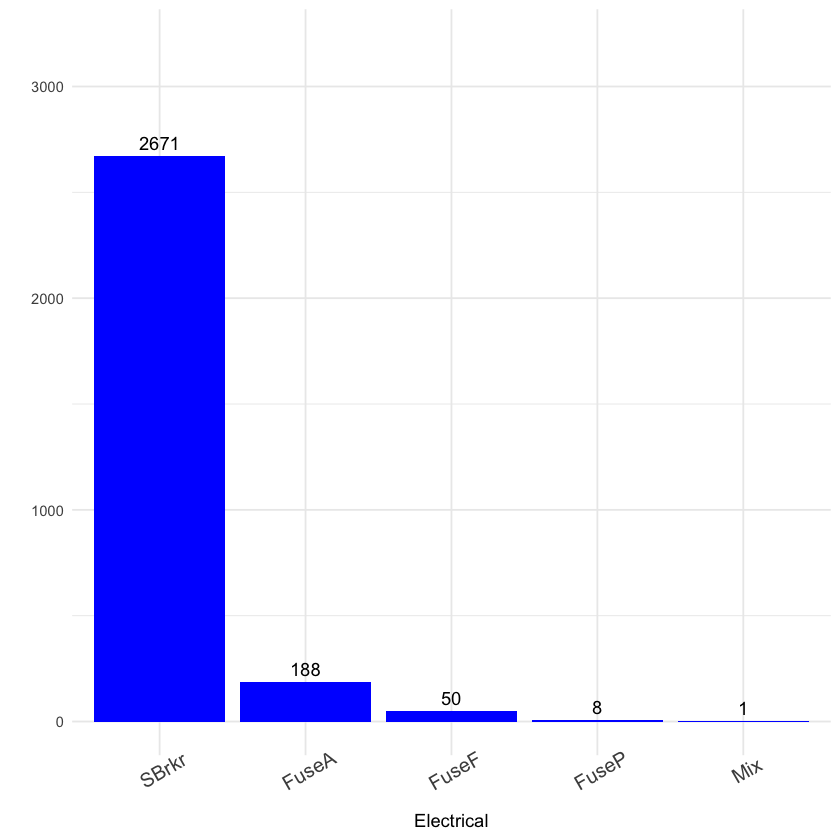

In [149]:
plot.categoric('KitchenQual', house.price.combined)
house.price.combined$KitchenQual[is.na(house.price.combined$KitchenQual)] = 'TA'
plot.categoric('Electrical', house.price.combined)
house.price.combined$Electrical[is.na(house.price.combined$Electrical)] = 'SBrkr'
paste('There are', sum(sapply(house.price.combined['KitchenQual'], is.na)), 'missing values left')
paste('There are', sum(sapply(house.price.combined['Electrical'], is.na)), 'missing values left')

#### Alley

There are 2721 missing values for Alley and only 2 potential options - Grvl and Pave. We fill ‘None’ for any of the houses with NA’s as these houses do not have any type of alley access.

Warning message:
“Removed 2721 rows containing non-finite values (stat_count).”Warning message:
“Removed 2721 rows containing non-finite values (stat_count).”Warning message:
“Removed 2721 rows containing non-finite values (stat_count).”

[1] "There are 0 missing values left"

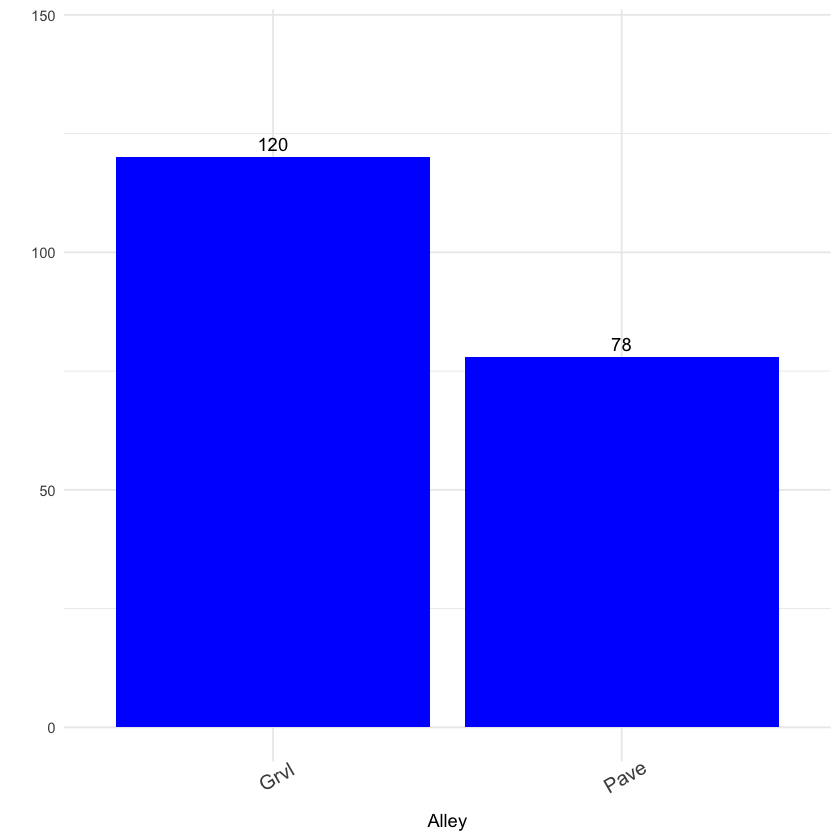

In [150]:
plot.categoric('Alley', house.price.combined)
house.price.combined$Alley[is.na(house.price.combined$Alley)] = 'None'
paste('There are', sum(sapply(house.price.combined['Alley'], is.na)), 'missing values left')

#### MiscFeature and Fence

We can replace any missing values for Fence and MiscFeature with ‘None’ as they probably don’t have this feature with their property.

Warning message:
“Removed 2348 rows containing non-finite values (stat_count).”Warning message:
“Removed 2348 rows containing non-finite values (stat_count).”Warning message:
“Removed 2348 rows containing non-finite values (stat_count).”

[1] "There are 0 missing values left"

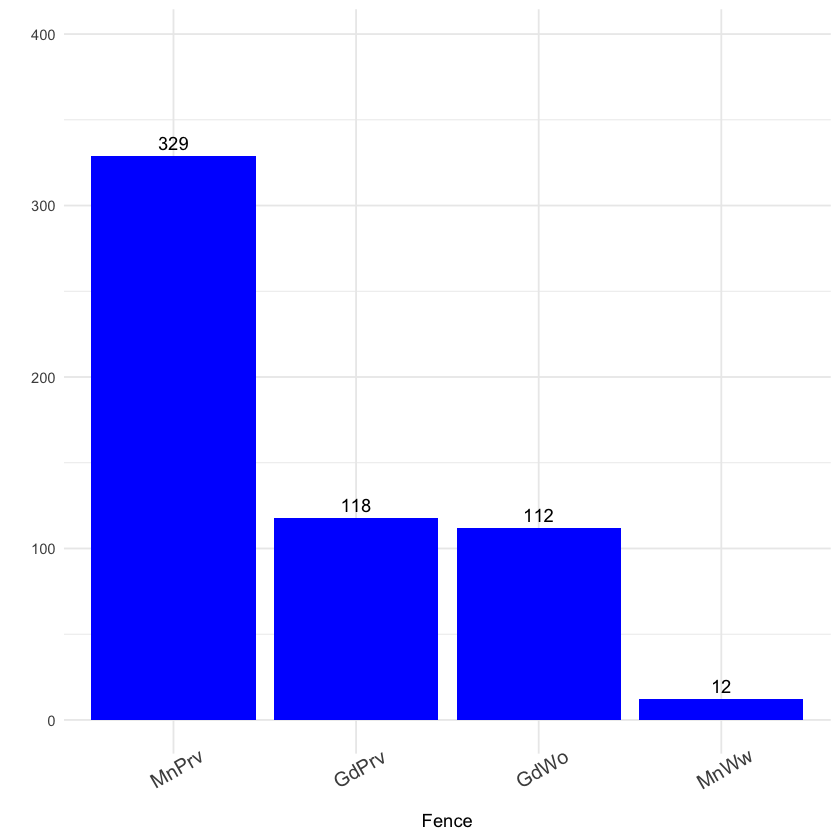

In [151]:
plot.categoric('Fence', house.price.combined)
house.price.combined$Fence[is.na(house.price.combined$Fence)] = 'None'
paste('There are', sum(sapply(house.price.combined['Fence'], is.na)), 'missing values left')

Warning message:
“Removed 2814 rows containing non-finite values (stat_count).”Warning message:
“Removed 2814 rows containing non-finite values (stat_count).”Warning message:
“Removed 2814 rows containing non-finite values (stat_count).”

[1] "There are 0 missing values left"

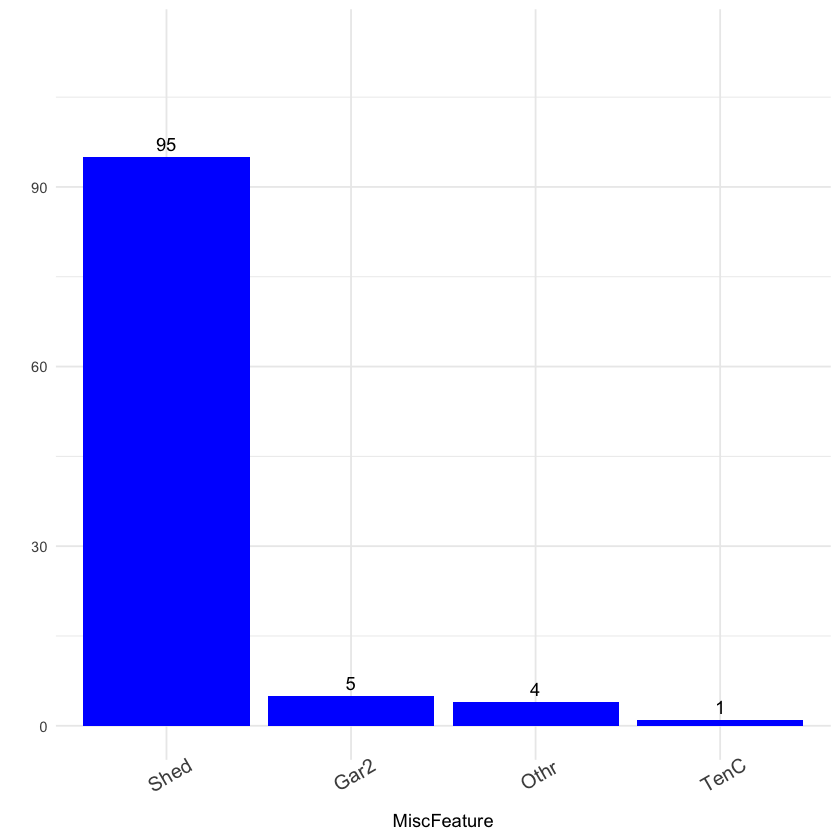

In [152]:
plot.categoric('MiscFeature', house.price.combined)
house.price.combined$MiscFeature[is.na(house.price.combined$MiscFeature)] = 'None'
paste('There are', sum(sapply(house.price.combined['MiscFeature'], is.na)), 'missing values left')

#### FireplaceQu and Fireplaces

We can check to see if any of the missing values for FireplaceQu come from houses that recorded having at least 1 fireplace. We can see that there are no such houses. All the houses that have missing values did not record having any fireplaces. We can replace the NAs with 'None' since these houses don’t have any fireplaces at all.

Warning message:
“Removed 1420 rows containing non-finite values (stat_count).”Warning message:
“Removed 1420 rows containing non-finite values (stat_count).”Warning message:
“Removed 1420 rows containing non-finite values (stat_count).”

[1] 0

[1] "There are 0 missing values left"

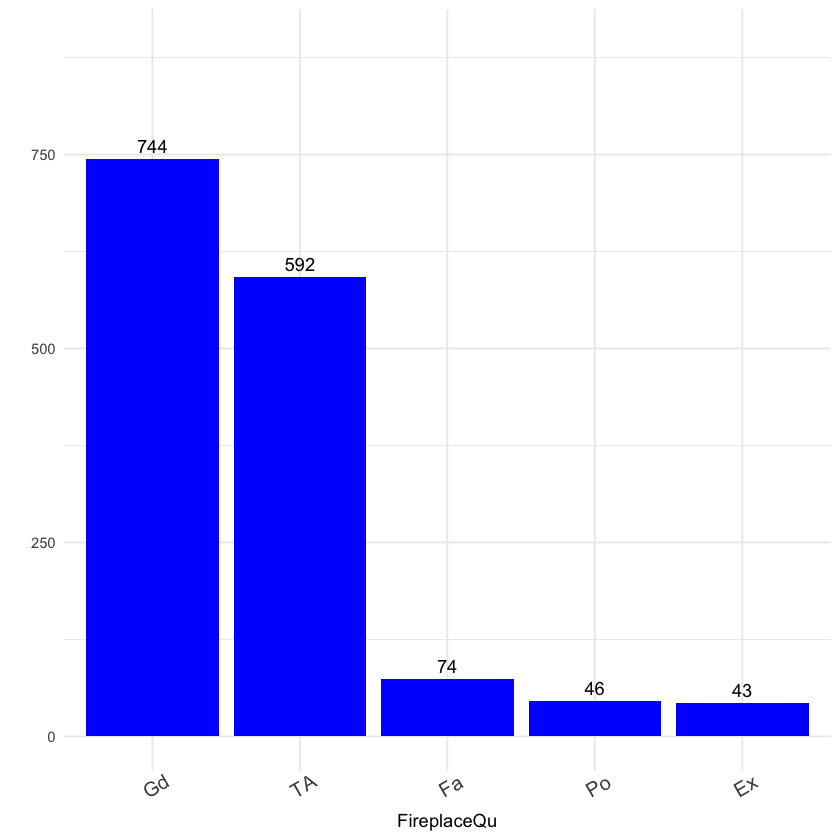

In [153]:
plot.categoric('FireplaceQu', house.price.combined)
sum((house.price.combined$Fireplaces > 0) & (is.na(house.price.combined$FireplaceQu)))
house.price.combined$FireplaceQu[is.na(house.price.combined$FireplaceQu)] = 'None'
paste('There are', sum(sapply(house.price.combined['FireplaceQu'], is.na)), 'missing values left')

#### Exterior1st and Exterior2nd

There is only 1 missing value for Exterior1st and Exterior2nd coming from the same house and there are not any features that can help us predict what variable should be filled. We can fill this with 'Other' since the NA is most likely due to having an exterior cover that is not listed.

Warning message:
“Removed 1 rows containing non-finite values (stat_count).”Warning message:
“Removed 1 rows containing non-finite values (stat_count).”Warning message:
“Removed 1 rows containing non-finite values (stat_count).”Warning message:
“Removed 1 rows containing non-finite values (stat_count).”Warning message:
“Removed 1 rows containing non-finite values (stat_count).”Warning message:
“Removed 1 rows containing non-finite values (stat_count).”

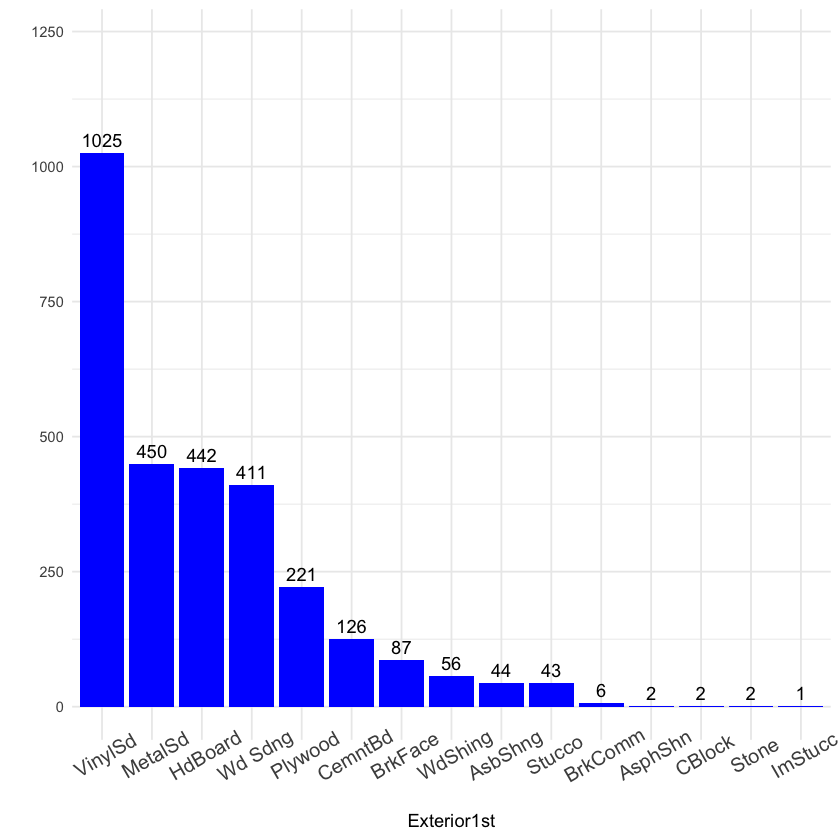

,Exterior1st,Exterior2nd
2152,NA,NA


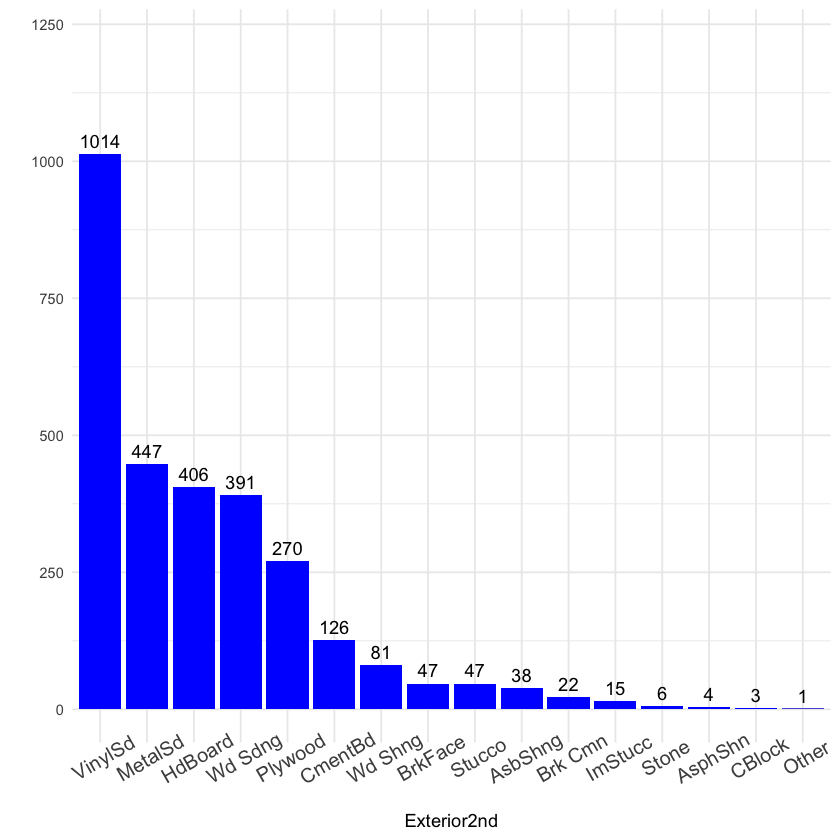

In [154]:
plot.categoric(c('Exterior1st', 'Exterior2nd'), house.price.combined)
idx <- which(is.na(house.price.combined$Exterior1st) | is.na(house.price.combined$Exterior2nd))
house.price.combined[idx,c('Exterior1st', 'Exterior2nd')]

For the ID 2152, we find that there are missing values.

In [155]:
house.price.combined$Exterior1st[is.na(house.price.combined$Exterior1st)] = 'Other'
house.price.combined$Exterior2nd[is.na(house.price.combined$Exterior2nd)] = 'Other'
paste('There are', sum(sapply(house.price.combined[,c('Exterior1st','Exterior2nd')], is.na)), 'missing values left')

[1] "There are 0 missing values left"

#### Functional, Utilities & SaleType

SaleType , Functional and Utilities have less than 3 missing values each. For SaleType we can see what the SaleCondition of the house was and use a contingency table to see which SaleType and SaleCondition overlap together the most. Most houses with a SaleCondition of 'Normal' almost all have a SaleType of 'WD'. We replace the missing value accordingly. For Functional, we use the value of 'Typ' as it the most common value. Utilities only has 1 value for NoSeWa and the rest AllPub. We can drop this feature from our dataset.

Warning message:
“Removed 1 rows containing non-finite values (stat_count).”Warning message:
“Removed 1 rows containing non-finite values (stat_count).”Warning message:
“Removed 1 rows containing non-finite values (stat_count).”

[1] "The type of SalesCondition is Normal"

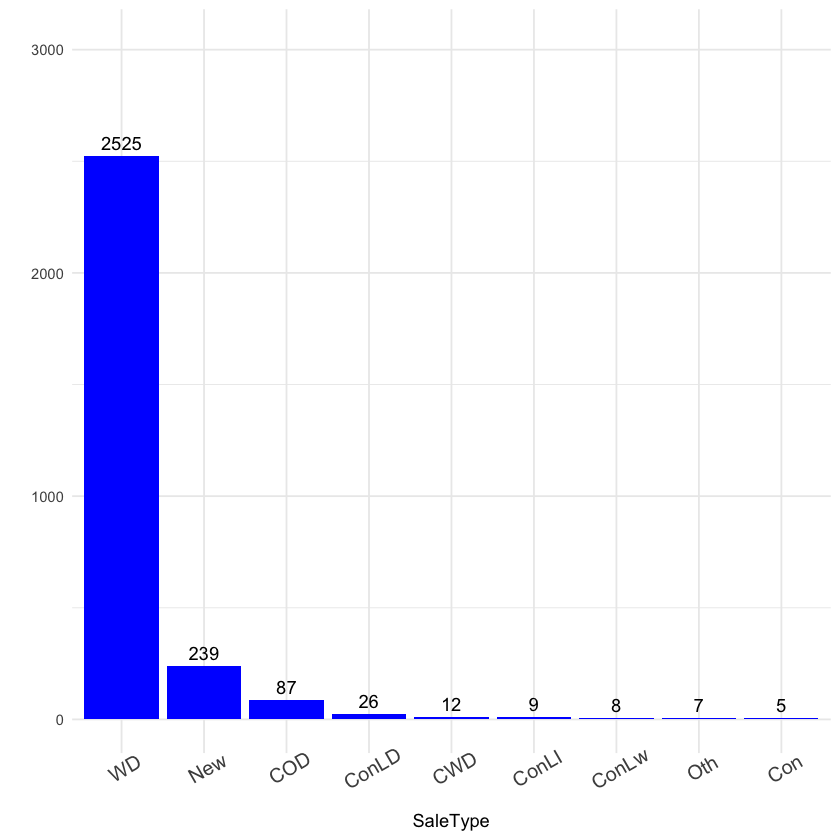

In [156]:
plot.categoric('SaleType', house.price.combined)
paste('The type of SalesCondition is',house.price.combined[is.na(house.price.combined$SaleType),c('SaleCondition')])

In [157]:
table(house.price.combined$SaleCondition, house.price.combined$SaleType)
house.price.combined$SaleType[is.na(house.price.combined$SaleType)] = 'WD'

         
           COD  Con ConLD ConLI ConLw  CWD  New  Oth   WD
  Abnorml   46    0     3     2     0    1    0    5  133
  AdjLand    0    0     0     0     0    0    0    0   12
  Alloca     0    0     0     0     0    0    0    0   24
  Family     2    0     1     2     1    1    0    1   38
  Normal    39    4    21     5     7   10    0    1 2314
  Partial    0    1     1     0     0    0  239    0    4

Warning message:
“Removed 2 rows containing non-finite values (stat_count).”Warning message:
“Removed 2 rows containing non-finite values (stat_count).”Warning message:
“Removed 2 rows containing non-finite values (stat_count).”

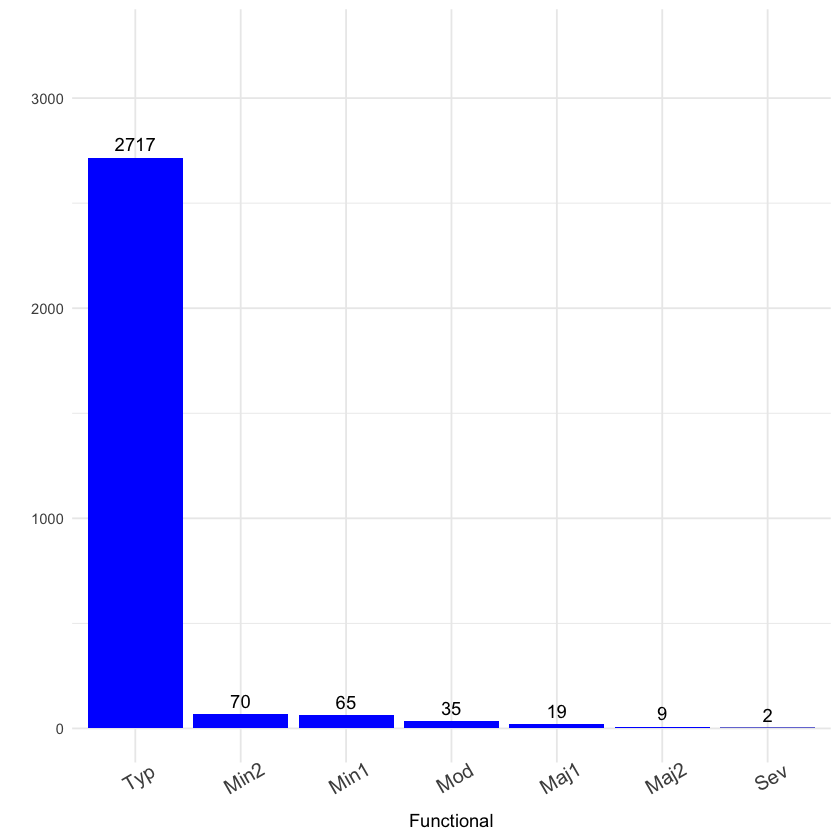

In [158]:
plot.categoric('Functional', house.price.combined)
house.price.combined$Functional[is.na(house.price.combined$Functional)] = 'Typ'

Warning message:
“Removed 2 rows containing non-finite values (stat_count).”Warning message:
“Removed 2 rows containing non-finite values (stat_count).”Warning message:
“Removed 2 rows containing non-finite values (stat_count).”

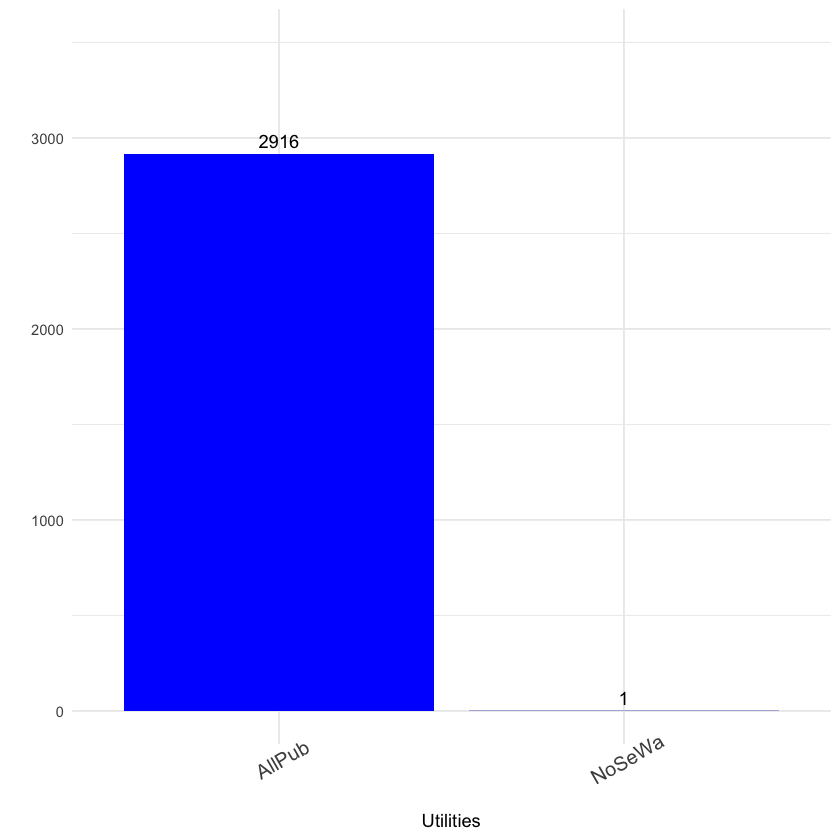

In [159]:
plot.categoric('Utilities', house.price.combined)

In [160]:
cols.drops <- c('Utilities')
house.price.combined <- house.price.combined[,!names(house.price.combined) %in% cols.drops]

In [161]:
paste('There are', sum(sapply(house.price.combined[,c('SaleType','Functional')], is.na)), 'missing values left')

[1] "There are 0 missing values left"

#### LotFrontage

There are 486 missing values for LotFrontage, which is quite a lot of values to fill and we cannot just replace these with 0. We are given that LotFrontage: Linear feet of street connected to property. We use the LotArea to come up with a reasonable estimate.

[1] "The median of the distribution of the Lots ' breadth is 1.92307692307692"

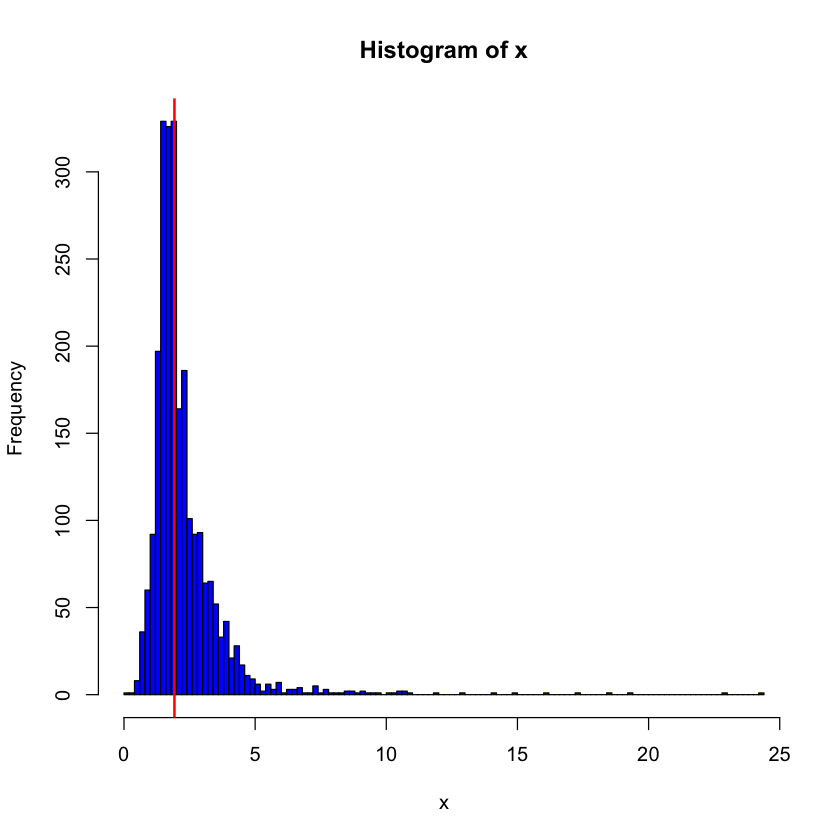

In [162]:
x <- na.omit(house.price.combined$LotArea/(house.price.combined$LotFrontage*house.price.combined$LotFrontage))
h<-hist(x,breaks=100, col = COLOUR)
abline(v = median(x),
 col = "red",
 lwd = 2)
paste('The median of the distribution of the Lots \' breadth is',median(x))

In [163]:
 house.price.combined[is.na(house.price.combined['LotFrontage']),'LotFrontage']<-sqrt(house.price.combined[is.na(house.price.combined['LotFrontage']),'LotArea']/2)

In [164]:
paste('There are', sum(sapply(house.price.combined[,c('LotFrontage')], is.na)), 'missing values left')

[1] "There are 0 missing values left"

#### MasVnrType & MasVnrArea

There are 23 missing values for MasVnrArea and 24 for MasVnrType . We can see if both missing values come from the same houses. If yes, it means that these houses do not have the property of Masonry Veneer at all.

In [165]:
house.price.combined[(is.na(house.price.combined$MasVnrType)) | (is.na(house.price.combined$MasVnrArea)), c('MasVnrType', 'MasVnrArea')]

,MasVnrType,MasVnrArea
235,NA,NA
530,NA,NA
651,NA,NA
937,NA,NA
974,NA,NA
978,NA,NA
1244,NA,NA
1279,NA,NA
1692,NA,NA
1707,NA,NA


All but one house has missing values for both columns. For houses with NAs on both columns we can fill 0 for the area and None for the type since they likely do not have a masonry veneer. For the house with a MasVnrArea of 198 but NA for MasVnrType we can record the median areas for each type and see which type is closest to 198.

In [166]:
na.omit(house.price.combined[,c('MasVnrType','MasVnrArea')]) %>%
group_by(na.omit(MasVnrType)) %>%
summarise(MedianArea = median(MasVnrArea,na.rm = TRUE), counts = n()) %>%
arrange(MedianArea)
house.price.combined$MasVnrType[is.na(house.price.combined$MasVnrType)] = 'None'
house.price.combined$MasVnrArea[is.na(house.price.combined$MasVnrArea)] = 0
house.price.combined[2611, 'MasVnrType'] = 'BrkFace'
paste('There are', sum(sapply(house.price.combined[,c('MasVnrType','MasVnrArea')], is.na)), 'missing values left')

na.omit(MasVnrType),MedianArea,counts
None,0,1742
BrkCmn,161,25
Stone,200,249
BrkFace,203,879


[1] "There are 0 missing values left"

#### MSZoning

There are only 4 missing values for MSZoning. We can see what the subclass is for the houses with missing values for MSZoning.

Warning message:
“Removed 4 rows containing non-finite values (stat_count).”Warning message:
“Removed 4 rows containing non-finite values (stat_count).”Warning message:
“Removed 4 rows containing non-finite values (stat_count).”

,MSZoning,MSSubClass
1916,NA,30
2217,NA,20
2251,NA,70
2905,NA,20


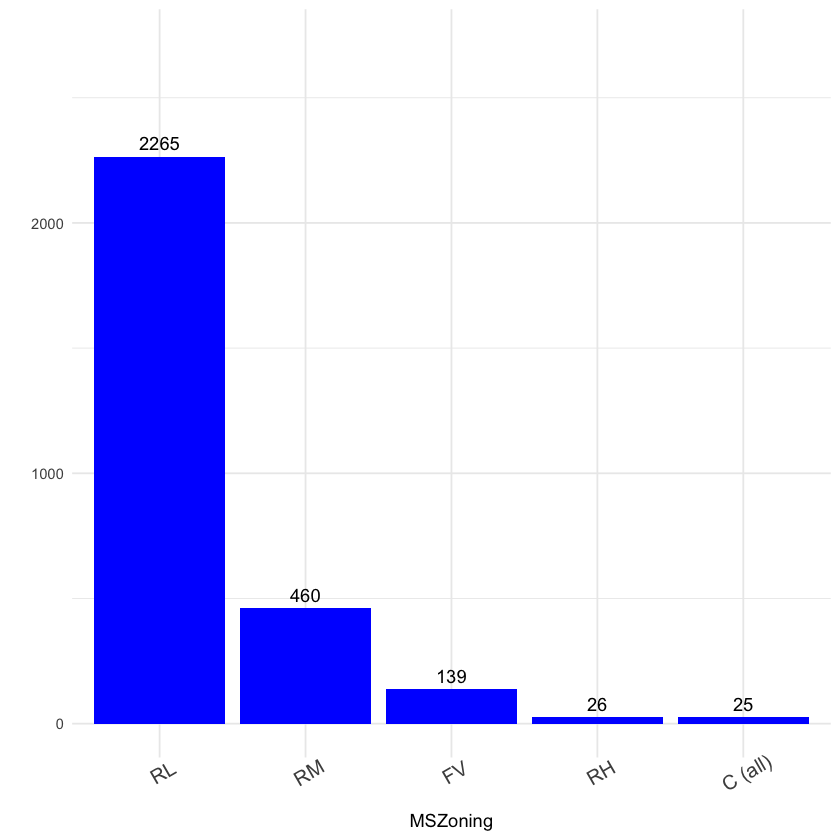

In [167]:
plot.categoric('MSZoning', house.price.combined)
house.price.combined[is.na(house.price.combined$MSZoning),c('MSZoning','MSSubClass')]

In [168]:
table(house.price.combined$MSZoning, house.price.combined$MSSubClass)

         
            20   30   40   45   50   60   70   75   80   85   90  120  150  160
  C (all)    3    8    0    0    7    0    4    0    0    0    0    0    0    0
  FV        34    0    0    0    0   43    0    0    0    0    0   19    0   43
  RH         4    2    0    1    2    0    3    0    0    0    4    6    0    0
  RL      1016   61    4    6  159  529   57    9  115   47   92  117    1   21
  RM        20   67    2   11  119    3   63   14    3    1   13   40    0   64
         
           180  190
  C (all)    0    3
  FV         0    0
  RH         0    4
  RL         0   31
  RM        17   23

For 20, RL has the largest frequency. For Subclasses with 30 and 70 RM has the most frequency.

In [169]:
house.price.combined$MSZoning[c(2217, 2905)] = 'RL'
house.price.combined$MSZoning[c(1916, 2251)] = 'RM'

#### Basement Features

There are 11 basement features each with at least 1 missing value. We take a look at the these columns from our data.

In [170]:
bsmt.cols <- names(house.price.combined)[sapply(names(house.price.combined), function(x) str_detect(x, 'Bsmt'))]
house.price.combined[is.na(house.price.combined[bsmt.cols]),bsmt.cols]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
18,NA,NA,NA,NA,0,NA,0,0,0,0,0
40,NA,NA,NA,NA,0,NA,0,0,0,0,0
91,NA,NA,NA,NA,0,NA,0,0,0,0,0
103,NA,NA,NA,NA,0,NA,0,0,0,0,0
157,NA,NA,NA,NA,0,NA,0,0,0,0,0
183,NA,NA,NA,NA,0,NA,0,0,0,0,0
260,NA,NA,NA,NA,0,NA,0,0,0,0,0
343,NA,NA,NA,NA,0,NA,0,0,0,0,0
363,NA,NA,NA,NA,0,NA,0,0,0,0,0
372,NA,NA,NA,NA,0,NA,0,0,0,0,0


Warning message:
“Removed 82 rows containing non-finite values (stat_count).”Warning message:
“Removed 82 rows containing non-finite values (stat_count).”Warning message:
“Removed 82 rows containing non-finite values (stat_count).”

[1] NA   NA   NA   NA   NA   NA   NA   NA   NA   NA   NA   NA   NA   NA   NA  
[16] NA   NA   NA   NA   NA   NA   NA   NA   "Gd" NA   NA   NA   NA   NA   NA  
[31] NA   NA   NA   NA   NA   NA   NA   NA   "Gd" NA   NA   NA   NA   NA   NA  
[46] NA   NA   NA   NA   NA   NA   NA   NA   NA   NA   NA   NA   NA   NA   NA  
[61] NA   NA   "Gd" NA   NA   NA   NA   NA   NA   NA   NA   NA   NA   NA   NA  
[76] NA   NA   NA   NA   NA   NA   NA

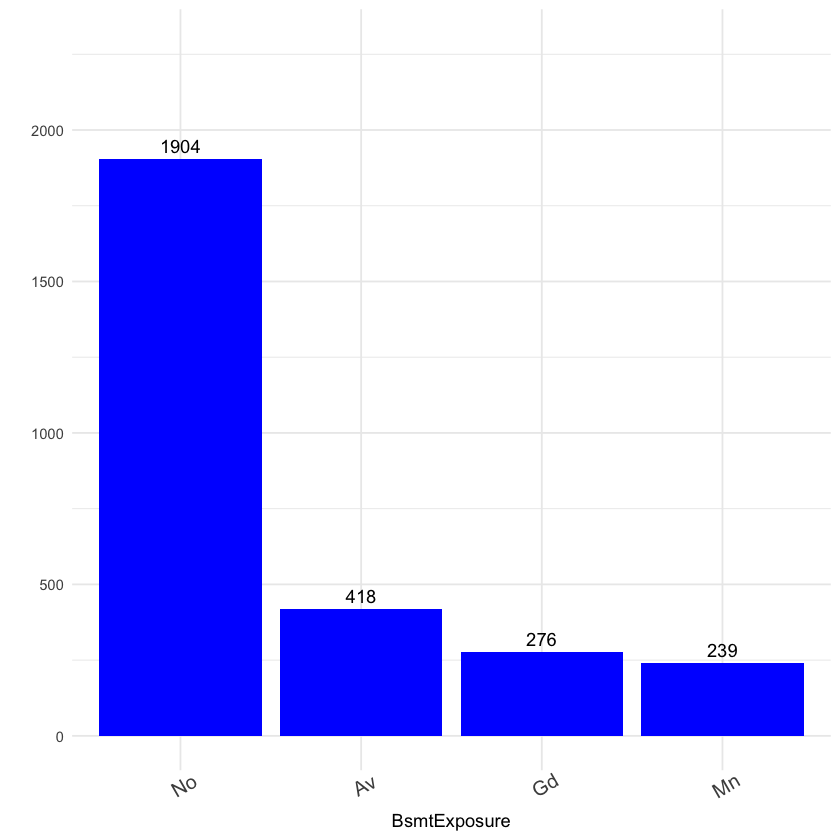

In [171]:
plot.categoric('BsmtExposure', house.price.combined)
house.price.combined[is.na(house.price.combined$BsmtExposure),'BsmtQual']

Almost all of the missing values for each categoric basement feature comes from houses with 0 on each features corresponding to area. We can fill in these values with ‘None’ since these houses certainly don’t have basements. Else, we can fill this with No as that is the most frequent value.

In [172]:
house.price.combined[c(949, 1488, 2349), 'BsmtExposure'] = 'No'
for (col in bsmt.cols)
{
    if (sapply(house.price.combined[col], is.numeric) == TRUE)
    {
        house.price.combined[sapply(house.price.combined[col], is.na),col] = 0
    }
    else
    {
        house.price.combined[sapply(house.price.combined[col],is.na),col] = 'None'
    }
}
getNA()

GarageYrBlt GarageFinish   GarageQual   GarageCond   GarageType   GarageCars 
         159          159          159          159          157            1 
  GarageArea 
           1

#### Garage Features

GarageYrBlt . It seems reasonable that most houses would build a garage when the house itself was built. That leaves 6 garage features in our dataset and 4 of them have at least 157 missing values while GarageArea and GarageCars both only have 1, thus we can assume this particular house does not have a garage at all. For the rest of the houses we can check to see that if the NA’s recorded also have 0 GarageArea and 0 GarageCars. If they do we can fill in their missing values with ‘None’ since having
0 area and 0 cars in their garage will imply that they do not have any at all.

In [173]:
garage.cols <- c('GarageArea', 'GarageCars', 'GarageQual', 'GarageFinish', 'GarageCond', 'GarageType')
house.price.combined[is.na(house.price.combined$GarageCond),garage.cols]

,GarageArea,GarageCars,GarageQual,GarageFinish,GarageCond,GarageType
40,0,0,NA,NA,NA,NA
49,0,0,NA,NA,NA,NA
79,0,0,NA,NA,NA,NA
89,0,0,NA,NA,NA,NA
90,0,0,NA,NA,NA,NA
100,0,0,NA,NA,NA,NA
109,0,0,NA,NA,NA,NA
126,0,0,NA,NA,NA,NA
128,0,0,NA,NA,NA,NA
141,0,0,NA,NA,NA,NA


In [174]:
house.price.combined[is.na(house.price.combined$GarageQual)& house.price.combined$GarageCars>0,garage.cols]

,GarageArea,GarageCars,GarageQual,GarageFinish,GarageCond,GarageType
2127,360,1,NA,NA,NA,Detchd
NA,NA,NA,NA,NA,NA,NA


Only one house who had NA in their garage columns had an area greater than 0. We can fill this house in manually and set the rest of the houses NA’s to 0. For the house with GarageArea = 360 and GarageCars = 1, but NA’s in the other columns, we can use the most frequent values for each columns from houses with a similar area and car count.

In [175]:
ids <- which(((house.price.combined$GarageArea < 370) & (house.price.combined$GarageArea > 350)) & (house.price.combined$GarageCars == 1))
names(sapply(house.price.combined[ids, garage.cols], function(x) sort(table(x), decreasing=TRUE)[1]))

[1] "GarageArea.352"    "GarageCars.1"      "GarageQual.TA"    
[4] "GarageFinish.Unf"  "GarageCond.TA"     "GarageType.Attchd"

In [176]:
idy <- which(is.na(house.price.combined$GarageYrBlt))
house.price.combined[idy, 'GarageYrBlt'] <- house.price.combined[idy, 'YearBuilt']
house.price.combined[2127,'GarageQual'] = 'TA'
house.price.combined[2127, 'GarageFinish'] = 'Unf'
house.price.combined[2127, 'GarageCond'] = 'TA'
for (col in garage.cols)
{
    if (sapply(house.price.combined[col], is.numeric) == TRUE)
    {
        house.price.combined[sapply(house.price.combined[col], is.na), col] = 0
    }
    else
    {
        house.price.combined[sapply(house.price.combined[col], is.na), col] = 'None'
    }
}

In [177]:
paste('There are', sum(sapply(house.price.combined, is.na)), 'missing values left')

[1] "There are 0 missing values left"

### Feature Engineering

By this point, we have filled in the missing values present in the training dataset. Before we do the data modelling, it is essential that we understands the relationship of the predictors(features) and the house price. Since we want a better model accuracy, we could classify the predictors into numerical and categorical variables. We transform categorical variables into numerical ones using one hot encoding technique.

In [178]:
temp<-house.price.train
house.price.train <- house.price.combined[1:1460,]
house.price.train$SalePrice <- temp$SalePrice
house.price.test<-house.price.combined[1461:dim(house.price.combined)[1],]
dim(house.price.train)
dim(house.price.test)

[1] 1460   79

[1] 1459   78

In [179]:
get.feature.numeric<-function(df)
{
     num_features <- names(which(sapply(df, is.numeric)))
     cat_features <- names(which(sapply(df, is.character)))

     df.numeric <- df[num_features]
    return(df.numeric)
}

In [180]:
num.cols<-get.feature.numeric(house.price.combined)
num.cols

MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,⋯,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
60,65.00000,8450,7,5,2003,2003,196,706,0,⋯,548,0,61,0,0,0,0,0,2,2008
20,80.00000,9600,6,8,1976,1976,0,978,0,⋯,460,298,0,0,0,0,0,0,5,2007
60,68.00000,11250,7,5,2001,2002,162,486,0,⋯,608,0,42,0,0,0,0,0,9,2008
70,60.00000,9550,7,5,1915,1970,0,216,0,⋯,642,0,35,272,0,0,0,0,2,2006
60,84.00000,14260,8,5,2000,2000,350,655,0,⋯,836,192,84,0,0,0,0,0,12,2008
50,85.00000,14115,5,5,1993,1995,0,732,0,⋯,480,40,30,0,320,0,0,700,10,2009
20,75.00000,10084,8,5,2004,2005,186,1369,0,⋯,636,255,57,0,0,0,0,0,8,2007
60,72.04859,10382,7,6,1973,1973,240,859,32,⋯,484,235,204,228,0,0,0,350,11,2009
50,51.00000,6120,7,5,1931,1950,0,0,0,⋯,468,90,0,205,0,0,0,0,4,2008
190,50.00000,7420,5,6,1939,1950,0,851,0,⋯,205,0,4,0,0,0,0,0,1,2008


### Relationship Between OverallQual and other Quality columns:Function col.house.price() quality.mean()

In order to come up with a reasonable numerical measure for the categorical feature, we need to see the relationship of the feature with the house price and the overall quality score of the house.

In [181]:
qual.cols <- c('ExterQual', 'ExterCond', 'GarageQual', 'GarageCond', 'FireplaceQu', 'KitchenQual', 'HeatingQC', 'BsmtQual')

In [182]:
col.house.price <- function(col, df) {
    col.house.table <- df[,c(col, 'SalePrice', 'OverallQual')] %>%
    group_by_(col) %>%
    summarise(mean.Quality = round(mean(OverallQual),2), mean.Price = mean(SalePrice), n = n()) %>%
    arrange(mean.Quality)
    
    print(qplot(x=reorder(col.house.table[[col]], -col.house.table[['mean.Price']]), y=col.house.table[['mean.Price']]) +
    geom_bar(stat='identity', fill='blue') +
    theme_minimal() +
    scale_y_continuous(labels = dollar_format(prefix="$")) +
    labs(x=col, y='Mean SalePrice') +
    theme(axis.text.x = element_text(angle = 45)))
  
  return(data.frame(col.house.table))
}
quality.mean <- function(col,df) {
    col.house.price <- df[,c(col, 'OverallQual')] %>%
    group_by_(col) %>%
    summarise(mean.qual = mean(OverallQual)) %>%
    arrange(mean.qual)
  
  return(data.frame(col.house.price))
}

FireplaceQu,mean.Quality,mean.Price,n
Po,4.95,129764.1,20
None,5.46,141331.5,690
Fa,5.76,167298.5,33
TA,6.48,205723.5,313
Gd,6.89,226351.4,380
Ex,8.38,337712.5,24


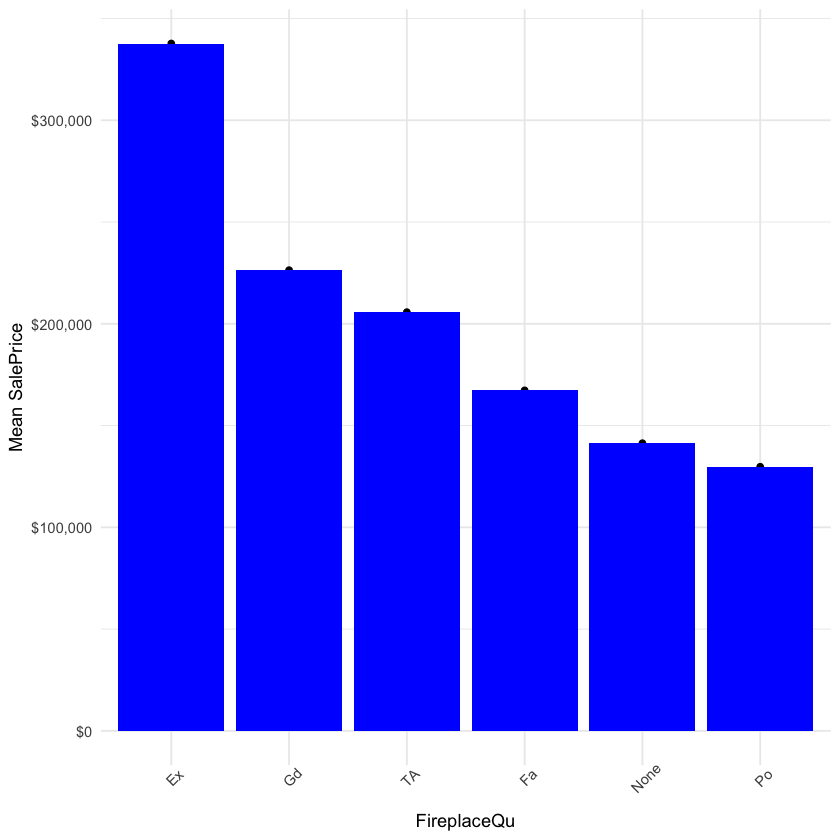

In [183]:
col.house.price(col ='FireplaceQu',df = house.price.train)
#col.house.price(col ='FireplaceQu',df = house.price.test)

BsmtQual,mean.Quality,mean.Price,n
None,4.30,105652.9,37
Fa,4.89,115692.0,35
TA,5.33,140759.8,649
Gd,6.66,202688.5,618
Ex,8.26,327041.0,121


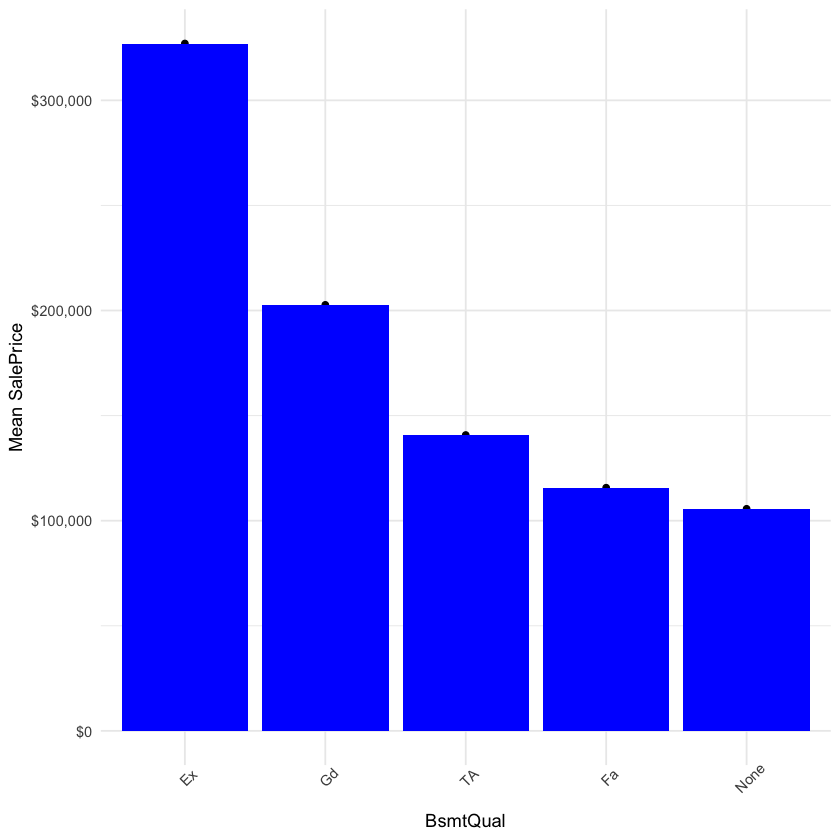

In [184]:
col.house.price(col = 'BsmtQual',df = house.price.train)

KitchenQual,mean.Quality,mean.Price,n
Fa,4.49,105565.2,39
TA,5.34,139962.5,735
Gd,6.79,212116.0,586
Ex,8.27,328554.7,100


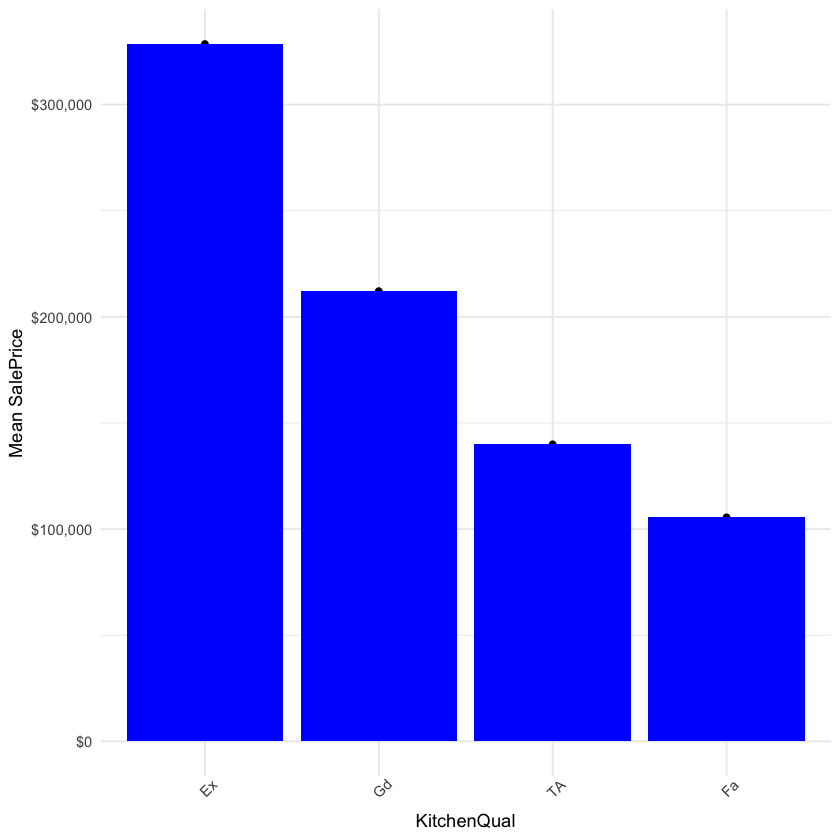

In [185]:
col.house.price(col = 'KitchenQual',df = house.price.train)

In [186]:
house.price.train$ExterQualOrigin = house.price.train$ExterQual
house.price.train$ExterCondOrigin = house.price.train$ExterCond
house.price.train$GarageQualOrigin = house.price.train$GarageQual
house.price.train$GarageCondOrigin = house.price.train$GarageCond
house.price.train$FireplaceQuOrigin = house.price.train$FireplaceQu
house.price.train$KitchenQualOrigin = house.price.train$KitchenQual
house.price.train$HeatingQCOrigin = house.price.train$HeatingQC
house.price.train$BsmtQualOrigin = house.price.train$BsmtQual

house.price.test$ExterQualOrigin = house.price.test$ExterQual
house.price.test$ExterCondOrigin = house.price.test$ExterCond
house.price.test$GarageQualOrigin = house.price.test$GarageQual
house.price.test$GarageCondOrigin = house.price.test$GarageCond
house.price.test$FireplaceQuOrigin = house.price.test$FireplaceQu
house.price.test$KitchenQualOrigin = house.price.test$KitchenQual
house.price.test$HeatingQCOrigin = house.price.test$HeatingQC
house.price.test$BsmtQualOrigin = house.price.test$BsmtQual

qual.list <- c('None' = 0, 'Po' = 1, 'Fa' = 2, 'TA' = 3, 'Gd' = 4, 'Ex' = 5)
map.fcn <- function(cols, map.list, df){
  for (col in cols){
    df[col] <- as.numeric(map.list[df[,col]])
  }
  return(df)
}
house.price.train<-map.fcn(cols = qual.cols,map.list = qual.list, df = house.price.train)
house.price.train[,qual.cols]

ExterQual,ExterCond,GarageQual,GarageCond,FireplaceQu,KitchenQual,HeatingQC,BsmtQual
4,3,3,3,0,4,5,4
3,3,3,3,3,3,5,4
4,3,3,3,3,4,5,4
3,3,3,3,4,4,4,3
4,3,3,3,3,4,5,4
3,3,3,3,0,3,5,4
4,3,3,3,4,4,5,5
3,3,3,3,3,3,5,4
3,3,2,3,3,3,4,3
3,3,4,3,3,3,5,3


In [187]:
house.price.test<-map.fcn(cols = qual.cols,map.list = qual.list, df = house.price.test)
house.price.test[,qual.cols]

,ExterQual,ExterCond,GarageQual,GarageCond,FireplaceQu,KitchenQual,HeatingQC,BsmtQual
1461,3,3,3,3,0,3,3,3
1462,3,3,3,3,0,4,3,3
1463,3,3,3,3,3,3,4,4
1464,3,3,3,3,4,4,5,3
1465,4,3,3,3,0,4,5,4
1466,3,3,3,3,3,3,4,4
1467,3,4,3,3,0,3,5,4
1468,3,3,3,3,4,3,4,4
1469,3,3,3,3,1,4,4,4
1470,3,3,3,3,0,3,3,3


BsmtExposure,mean.Quality,mean.Price,n
None,4.30,105652.9,37
No,5.92,165680.4,954
Mn,6.25,192789.7,114
Av,6.57,206643.4,221
Gd,6.96,257689.8,134


BsmtExposure
1
4
2
1
3
1
3
2
1
1


,BsmtExposure
1461,1
1462,1
1463,1
1464,1
1465,1
1466,1
1467,1
1468,1
1469,4
1470,1


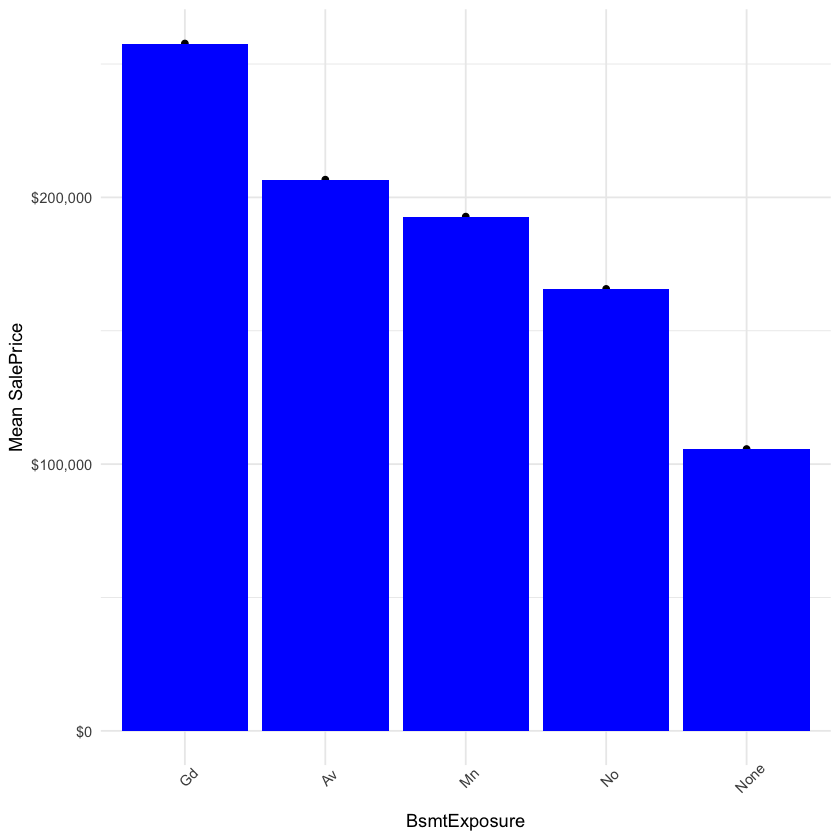

In [188]:
house.price.train$BsmtExposureOrigin = house.price.train$BsmtExposure
house.price.test$BsmtExposureOrigin = house.price.test$BsmtExposure

col.house.price(col = 'BsmtExposure', df = house.price.train)
bsmt.list <- c('None' = 0, 'No' = 1, 'Mn' = 2, 'Av' = 3, 'Gd' = 4)
house.price.train = map.fcn(c('BsmtExposure'), bsmt.list, house.price.train)
house.price.train['BsmtExposure']
house.price.test = map.fcn(c('BsmtExposure'), bsmt.list, house.price.test)
house.price.test['BsmtExposure']

BsmtFinType1,mean.Quality,mean.Price,n
None,4.30,105652.9,37
BLQ,5.35,149493.7,148
Rec,5.35,146889.2,133
LwQ,5.54,151852.7,74
ALQ,5.55,161573.1,220
Unf,6.20,170670.6,430
GLQ,7.05,235413.7,418


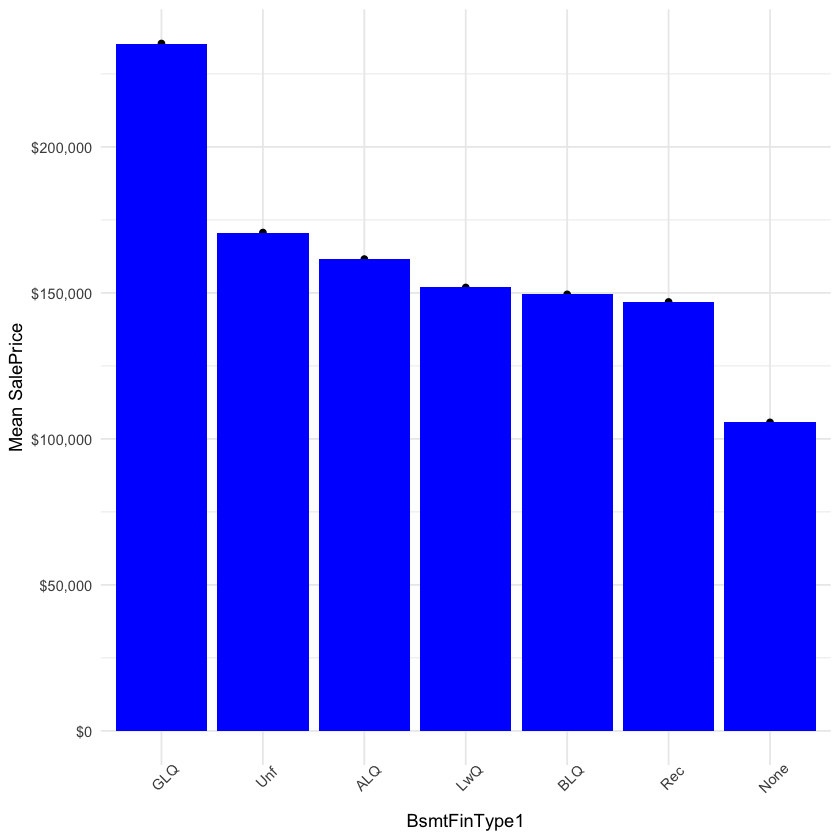

In [189]:
col.house.price(col = 'BsmtFinType1', df= house.price.train)

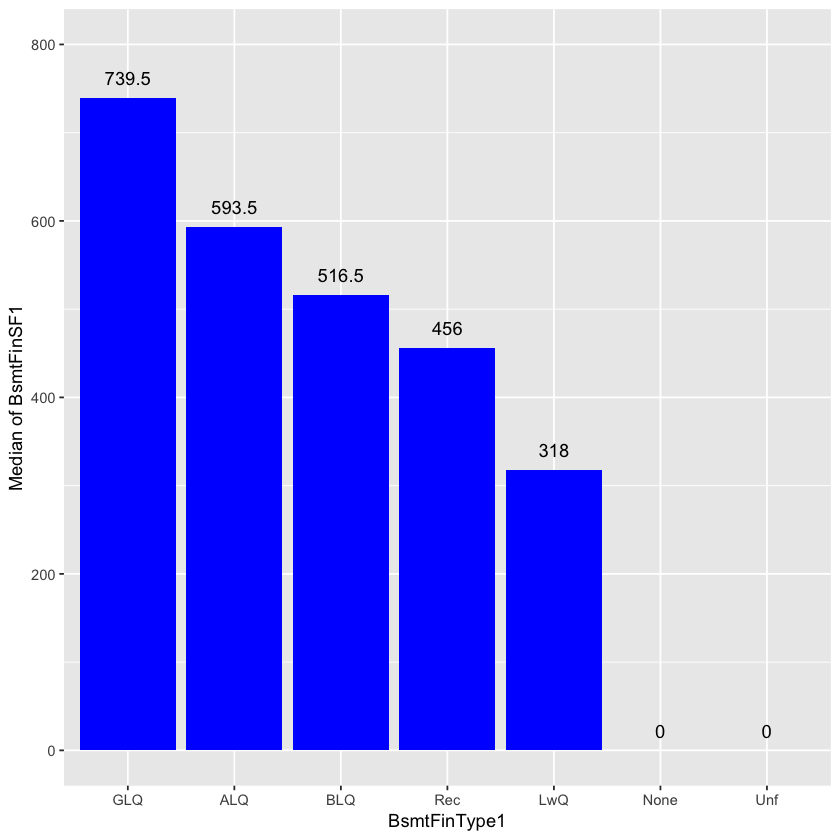

In [190]:
house.price.train[,c('BsmtFinType1', 'BsmtFinSF1')] %>%
  group_by(BsmtFinType1) %>%
  summarise(medianArea = median(BsmtFinSF1), counts = n()) %>%
  arrange(medianArea) %>%
  ggplot(aes(x=reorder(BsmtFinType1,-medianArea), y=medianArea)) +
  geom_bar(stat = 'identity', fill=COLOUR) +
  labs(x='BsmtFinType1', y='Median of BsmtFinSF1') +
  geom_text(aes(label = sort(medianArea),vjust=-1)) +
  scale_y_continuous(limits = c(0,800)) 

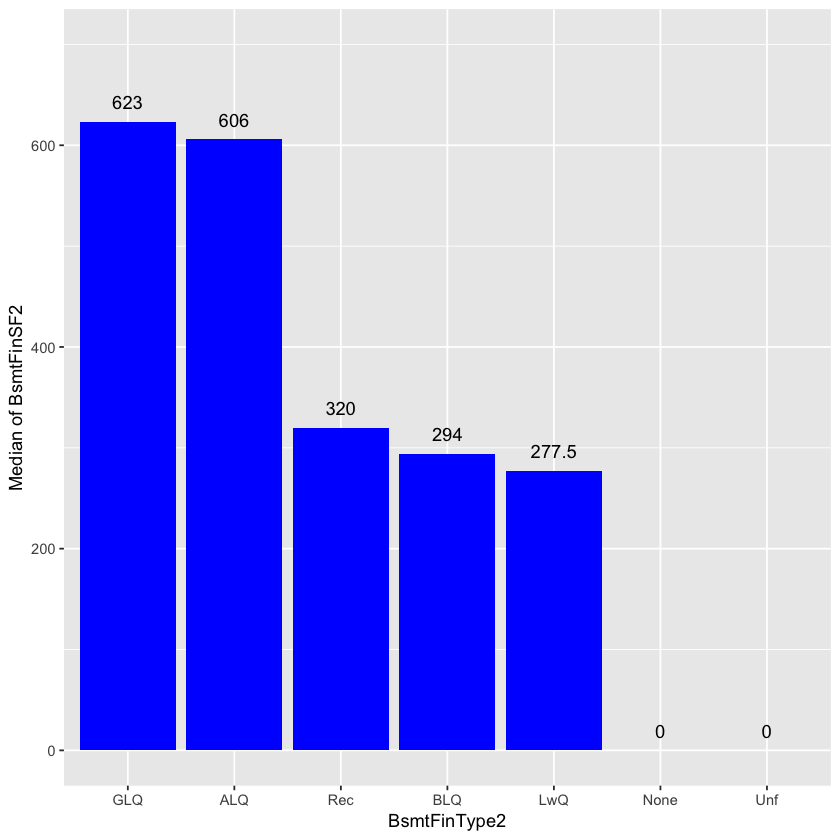

In [191]:
house.price.train[,c('BsmtFinType2', 'BsmtFinSF2')] %>%
  group_by(BsmtFinType2) %>%
  summarise(medianArea = median(BsmtFinSF2), counts = n()) %>%
  arrange(medianArea) %>%
  ggplot(aes(x=reorder(BsmtFinType2,-medianArea), y=medianArea)) +
  geom_bar(stat = 'identity', fill=COLOUR) +
  labs(x='BsmtFinType2', y='Median of BsmtFinSF2') +
  geom_text(aes(label = sort(medianArea),vjust=-1)) +
  scale_y_continuous(limits = c(0,700)) 

We can see the exact order of the Basement Finish Type columns. It follows GLQ>ALQ>BLQ>LWQ>Unf>None.

In [192]:
house.price.train$BsmtFinType1Origin = house.price.train$BsmtFinType1
house.price.test$BsmtFinType1Origin = house.price.test$BsmtFinType1

house.price.train$BsmtFinType2Origin = house.price.train$BsmtFinType2
house.price.test$BsmtFinType2Origin = house.price.test$BsmtFinType2

bsmt.fin.list <- c('None' = 0, 'Unf' = 1, 'LwQ' = 2,'Rec'= 3, 'BLQ' = 4, 'ALQ' = 5, 'GLQ' = 6)
house.price.train <- map.fcn(c('BsmtFinType1','BsmtFinType2'), bsmt.fin.list, house.price.train)
house.price.test <- map.fcn(c('BsmtFinType1','BsmtFinType2'), bsmt.fin.list, house.price.test)
head(house.price.train[c('BsmtFinType1','BsmtFinType2')])
head(house.price.test[c('BsmtFinType1','BsmtFinType2')])

BsmtFinType1,BsmtFinType2
6,1
5,1
6,1
5,1
6,1
6,1


,BsmtFinType1,BsmtFinType2
1461,3,2
1462,5,1
1463,6,1
1464,6,1
1465,5,1
1466,1,1


Functional,mean.Quality,mean.Price,n
Min2,4.97,144240.6,34
Maj2,5.00,85800.0,5
Min1,5.26,146385.5,31
Mod,5.40,168393.3,15
Maj1,5.50,153948.1,14
Sev,6.00,129000.0,1
Typ,6.16,183429.1,1360


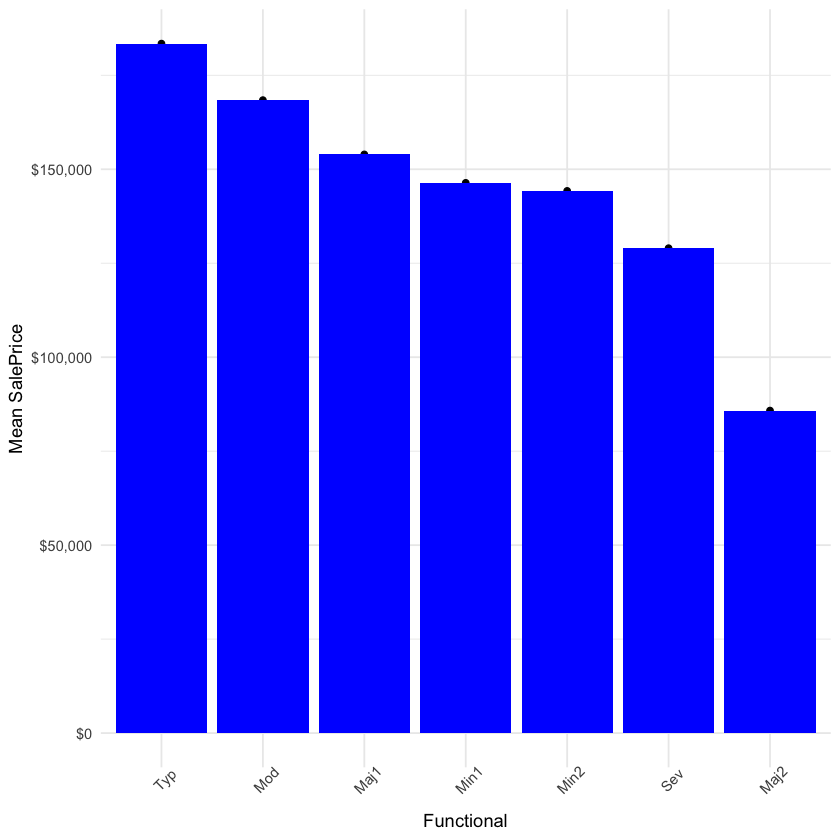

In [193]:
col.house.price(col = 'Functional', df=house.price.train)

In [194]:
house.price.train$FunctionalOrigin = house.price.train$Functional
house.price.test$FunctionalOrigin = house.price.test$Functional


fun.list <- c('None' = 0, 'Sal' = 1, 'Sev' = 2, 'Maj2' = 3, 'Maj1' = 4, 'Mod' = 5, 'Min2' = 6, 'Min1' = 7, 'Typ'= 8)
house.price.train <- map.fcn('Functional', fun.list, house.price.train)
head(house.price.train ['Functional'])
house.price.test <- map.fcn('Functional', fun.list, house.price.test)
head(house.price.test ['Functional'])

Functional
8
8
8
8
8
8


,Functional
1461,8
1462,8
1463,8
1464,8
1465,8
1466,8


GarageFinish,mean.Quality,mean.Price,n
None,4.60,103317.3,81
Unf,5.40,142156.4,605
RFn,6.57,202068.9,422
Fin,7.07,240052.7,352


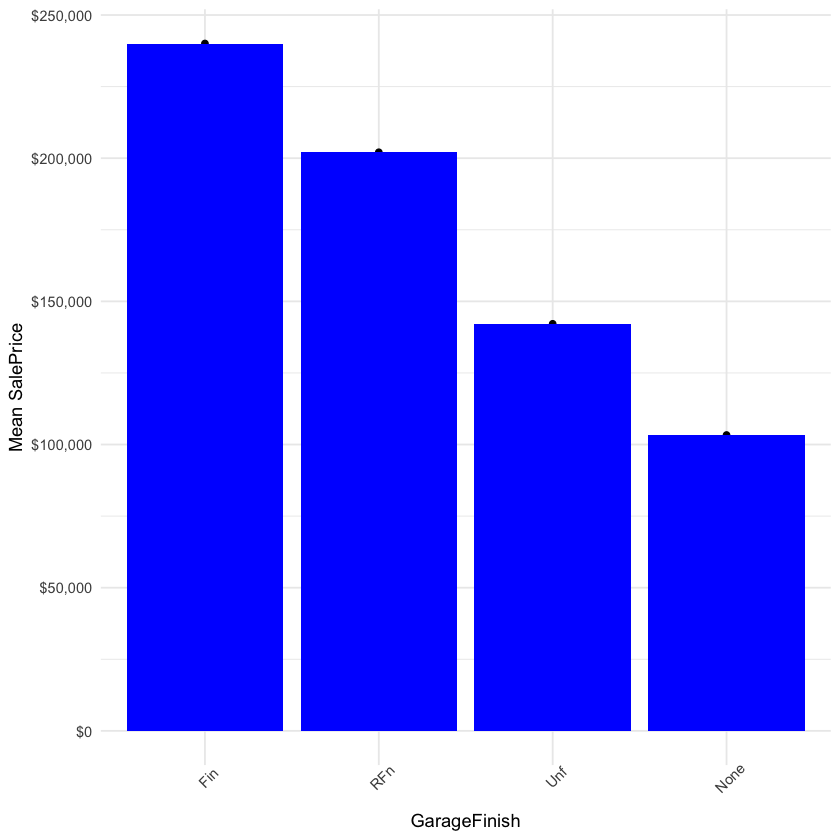

In [195]:
col.house.price(col='GarageFinish', df= house.price.train)

In [196]:
house.price.train$GarageFinishOrigin = house.price.train$GarageFinish
house.price.test$GarageFinishOrigin = house.price.test$GarageFinish

garage.fin.list <- c('None' = 0,'Unf' = 1, 'RFn' = 1, 'Fin' = 2)
house.price.train <- map.fcn('GarageFinish', garage.fin.list, house.price.train)
head(house.price.train ['GarageFinish'])
house.price.test <- map.fcn('GarageFinish', garage.fin.list, house.price.test)
head(house.price.test ['GarageFinish'])

GarageFinish
1
1
1
1
1
1


,GarageFinish
1461,1
1462,1
1463,2
1464,2
1465,1
1466,2


Fence,mean.Quality,mean.Price,n
GdWo,5.17,140379.3,54
MnWw,5.18,134286.4,11
MnPrv,5.45,148751.1,157
None,6.23,187596.8,1179
GdPrv,6.31,178927.5,59


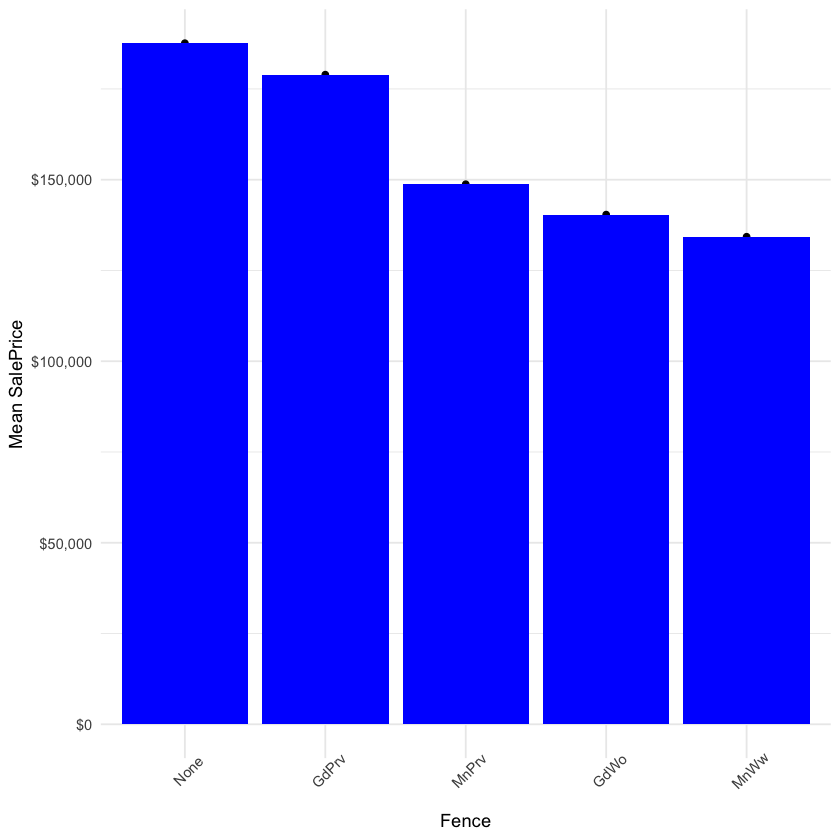

In [197]:
col.house.price(col='Fence', df= house.price.train)

In [198]:
house.price.train$FenceOrigin = house.price.train$Fence
house.price.test$FenceOrigin = house.price.test$Fence

fen.list <- c('None' = 0, 'MnWw' = 1, 'GdWo' = 1, 'MnPrv' = 2, 'GdPrv' = 4)
house.price.train <- map.fcn('Fence', fen.list, house.price.train)
head(house.price.train ['Fence'])
house.price.test <- map.fcn('Fence', fen.list, house.price.test)
head(house.price.test ['Fence'])

Fence
0
0
0
0
0
2


,Fence
1461,2
1462,0
1463,2
1464,0
1465,0
1466,0


In [199]:
house.price.train['NewHouse'] <- (house.price.train$YearBuilt == house.price.train$YrSold) * 1
house.price.test['NewHouse'] <- (house.price.test$YearBuilt == house.price.test$YrSold) * 1

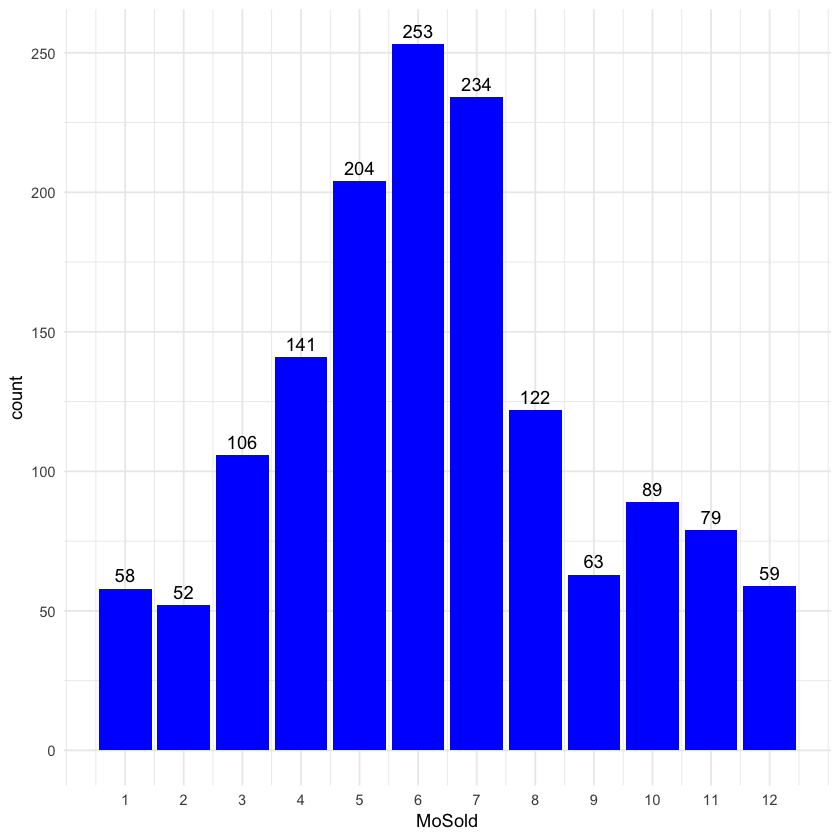

In [200]:
ggplot(house.price.train, aes(x=MoSold)) +
geom_bar(fill = COLOUR) +
geom_text(aes(label=..count..), stat='count', vjust = -.5) +
theme_minimal() +
scale_x_continuous(breaks = 1:12)

In [201]:
house.price.train['Season'] <- (house.price.train$MoSold %in% c(5,6,7)) * 1
house.price.test['Season'] <- (house.price.test$MoSold %in% c(5,6,7)) * 1

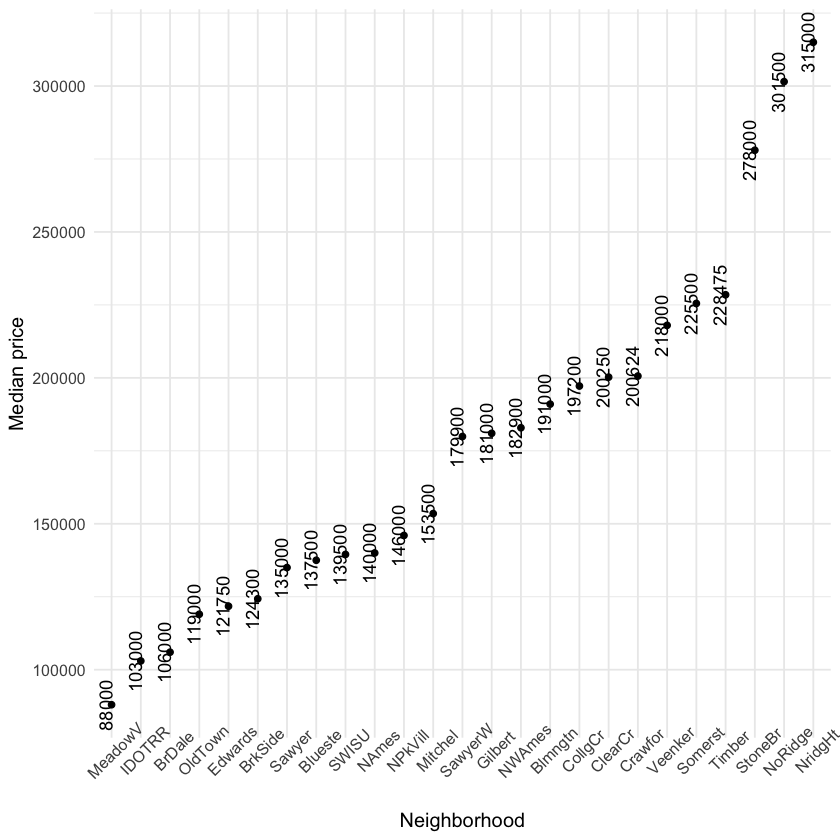

In [202]:
house.price.train[,c('Neighborhood','SalePrice')] %>%
group_by(Neighborhood) %>%
summarise(median.price = median(SalePrice, na.rm = TRUE)) %>%
arrange(median.price) %>%
mutate(nhbr.sorted = factor(Neighborhood, levels=Neighborhood)) %>%
ggplot(aes(x=nhbr.sorted, y=median.price)) +
geom_point() +
geom_text(aes(label = median.price, angle = 90), vjust = 0.1) +
theme_minimal() +
labs(x='Neighborhood', y='Median price') +
theme(text = element_text(size=12),
axis.text.x = element_text(angle=45))

Neighborhood,mean.Quality,mean.Price,n
MeadowV,4.47,98576.47,17
IDOTRR,4.76,100123.78,37
Sawyer,5.03,136793.14,74
BrkSide,5.05,124834.05,58
Edwards,5.08,128219.70,100
NAmes,5.36,145847.08,225
OldTown,5.39,128225.30,113
SWISU,5.44,142591.36,25
Mitchel,5.59,156270.12,49
BrDale,5.69,104493.75,16


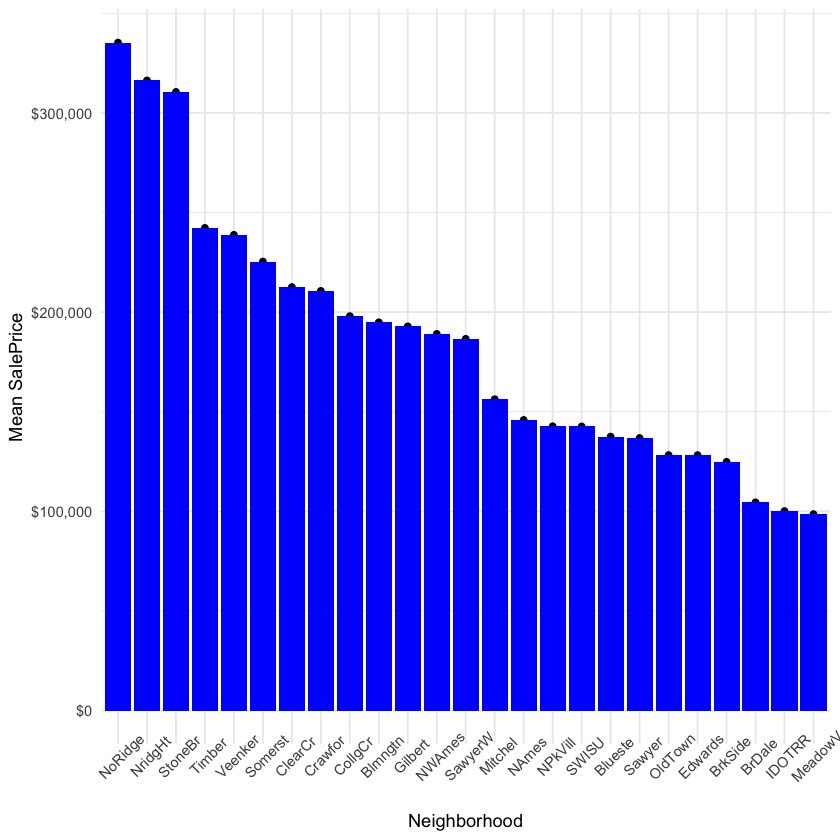

In [203]:
col.house.price(col='Neighborhood',df=house.price.train)

In [204]:
area.cols <- c('LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
'TotalBsmtSF', 'X1stFlrSF', 'X2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF',
'OpenPorchSF', 'EnclosedPorch', 'X3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea')
house.price.train['TotalArea'] <- as.numeric(rowSums(house.price.train[,area.cols]))
house.price.test['TotalArea'] <- as.numeric(rowSums(house.price.test[,area.cols]))

In [206]:
num_features_tr <- names(which(sapply(house.price.train, is.numeric)))
num_features_tr <- num_features_tr[num_features_tr!="Id"&num_features_tr!="MSSubClass"&num_features_tr!="YearBuilt"&num_features_tr!="YearRemodAdd"&num_features_tr!="YrSold"]
num_features_ts <- names(which(sapply(house.price.test, is.numeric)))
num_features_ts <- num_features_ts[num_features_ts!="Id"&num_features_ts!="MSSubClass"&num_features_ts!="YearBuilt"&num_features_ts!="YearRemodAdd"&num_features_ts!="YrSold"]


In [207]:
head(house.price.train[,num_features_tr])
head(house.price.test[,num_features_ts])

length(num_features_tr)
length(num_features_ts)

LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtExposure,BsmtFinType1,⋯,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,SalePrice,NewHouse,Season,TotalArea,AreaInside
65,8450,7,5,196,4,3,4,1,6,⋯,0,0,0,0,2,208500,0,0,14452,1710
80,9600,6,8,0,3,3,4,4,5,⋯,0,0,0,0,5,181500,0,1,15486,1262
68,11250,7,5,162,4,3,4,2,6,⋯,0,0,0,0,9,223500,0,0,17542,1786
60,9550,7,5,0,3,3,3,1,5,⋯,0,0,0,0,2,140000,0,0,15505,1717
84,14260,8,5,350,4,3,4,3,6,⋯,0,0,0,0,12,250000,0,0,22492,2198
85,14115,5,5,0,3,3,4,1,6,⋯,0,0,2,700,10,143000,0,0,19386,1362


,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtExposure,BsmtFinType1,⋯,X3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,NewHouse,Season,TotalArea,AreaInside
1461,80,11622,5,6,0,3,3,3,1,3,⋯,0,120,0,2,0,6,0,1,16248,896
1462,81,14267,6,6,108,3,3,3,1,5,⋯,0,0,0,0,12500,6,0,1,20513,1329
1463,74,13830,5,5,0,3,3,4,1,6,⋯,0,0,0,2,0,3,0,0,19746,1629
1464,78,9978,6,6,20,3,3,3,1,6,⋯,0,0,0,0,0,6,0,1,16002,1604
1465,43,5005,8,5,0,4,3,4,1,5,⋯,0,144,0,0,0,1,0,0,10900,1280
1466,75,10000,6,5,0,3,3,4,1,1,⋯,0,0,0,0,0,4,0,0,15592,1655


[1] 51

[1] 50

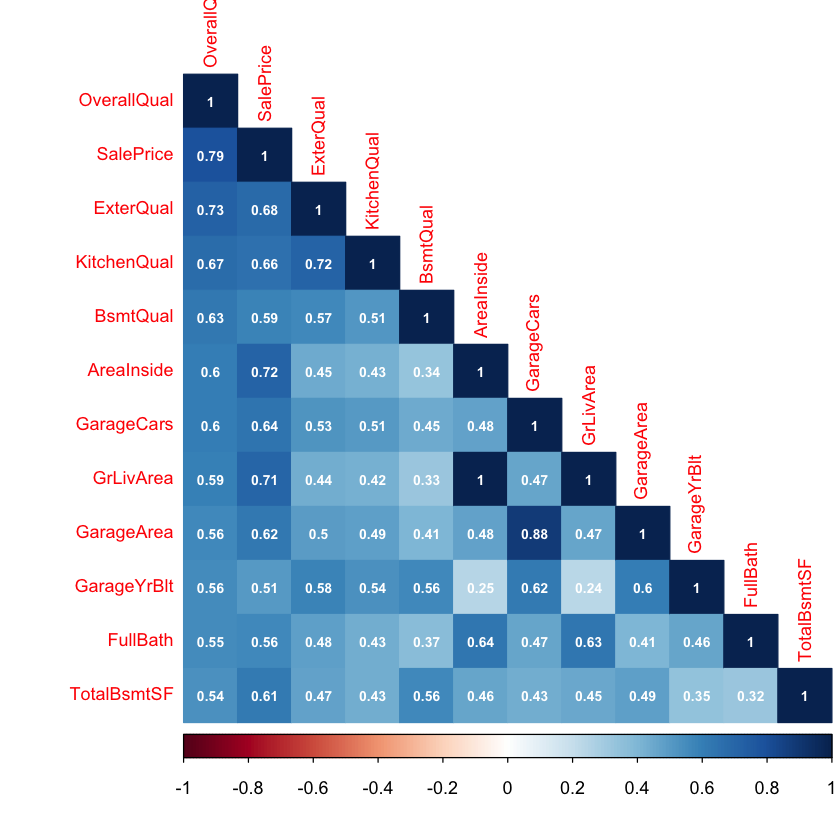

In [208]:
house.price.cor<-cor(house.price.train[num_features_tr])
cor.mat <- as.matrix(sort(house.price.cor[,'OverallQual'], decreasing = TRUE))
cor.id <- names(which(apply(cor.mat, 1, function(x) (x > 0.5 | x < -0.5))))
corrplot(as.matrix(house.price.cor[cor.id,cor.id]), type = 'lower', method='color', addCoef.col = 'white', tl.cex = .9,cl.cex = .9, number.cex=.7)

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 1.985”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 2.015”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  3.3371e-16”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 4.0602”Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“pseudoinverse used at 1.985”Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“neighborhood radius 2.015”Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) objec

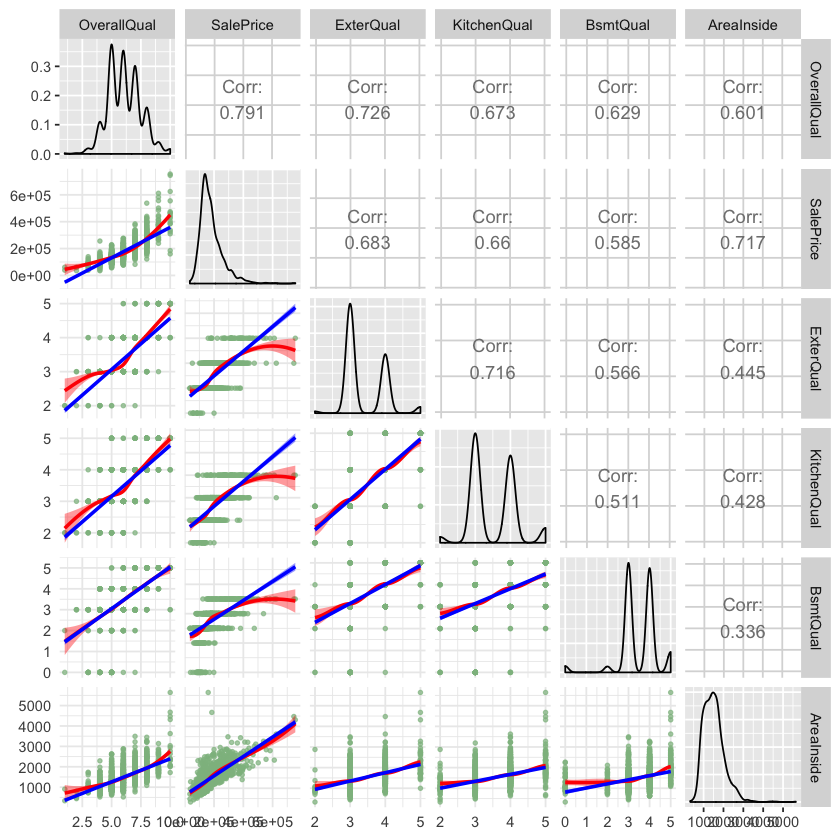

In [209]:
require(GGally)
lm.plt <- function(data, mapping, ...){
plt <- ggplot(data = data, mapping = mapping) +
geom_point(shape = 20, alpha = 0.7, color = 'darkseagreen') +
geom_smooth(method=loess, fill="red", color="red") +
geom_smooth(method=lm, fill="blue", color="blue") +
theme_minimal()
return(plt)
}
ggpairs(house.price.train[num_features_tr], cor.id[1:6], lower = list(continuous = lm.plt))

In [210]:
# ggpairs(house.price.train[num_features_tr], cor.id[c(1,7:15)], lower = list(continuous = lm.plt))

### Outliers Detection and Removal

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


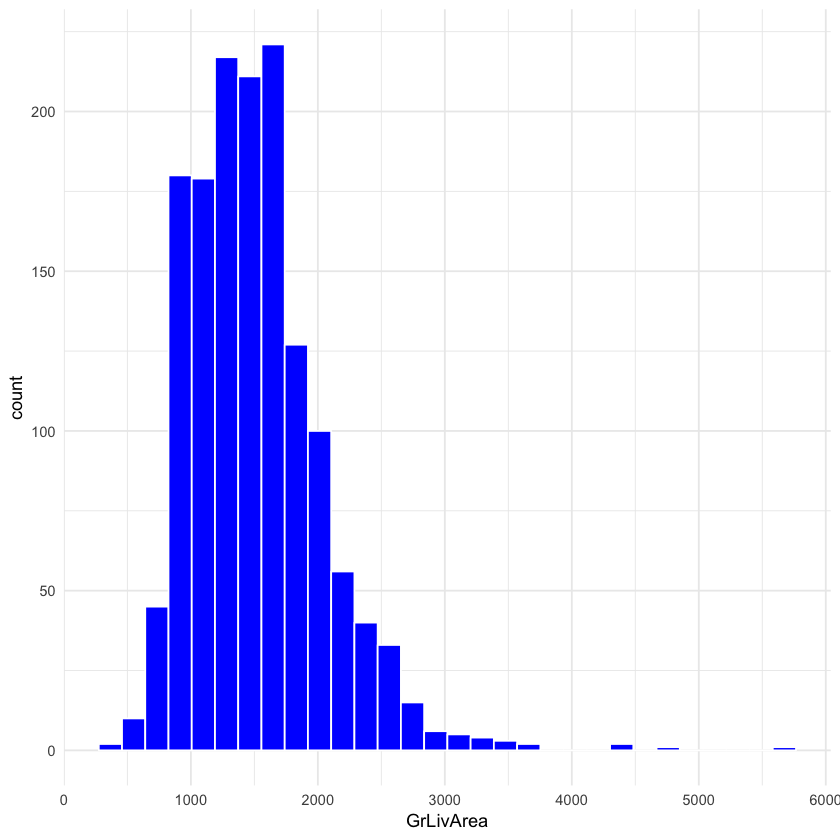

In [211]:
ggplot(house.price.train, aes(x=GrLivArea)) +
geom_histogram(fill='blue',color='white') +
theme_minimal()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


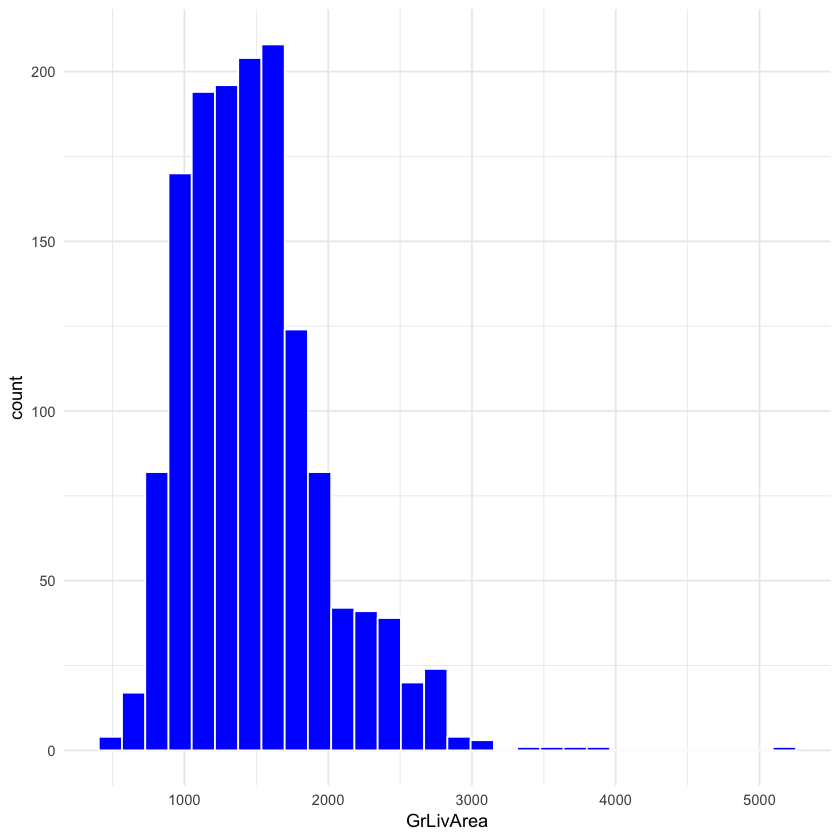

In [212]:
ggplot(house.price.test, aes(x=GrLivArea)) +
geom_histogram(fill='blue',color='white') +
theme_minimal()

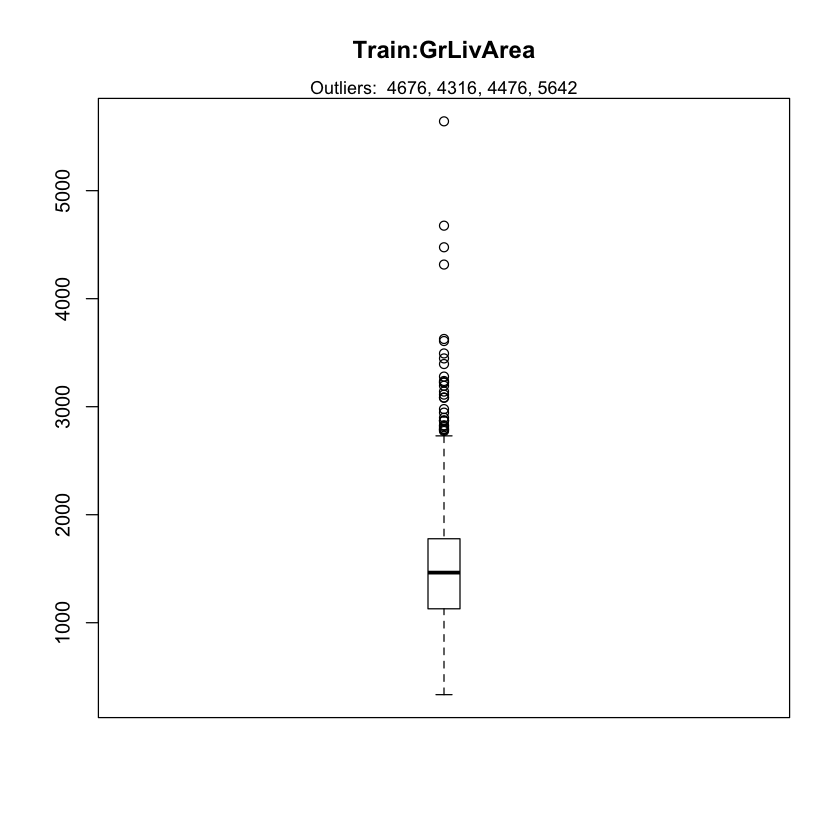

In [213]:
outlier_values <- boxplot.stats(house.price.train$GrLivArea)$out # outlier values.
boxplot(house.price.train$GrLivArea, main="Train:GrLivArea", boxwex=0.1)
mtext(paste("Outliers: ", paste(outlier_values[outlier_values>4000], collapse=", ")), cex=0.9)

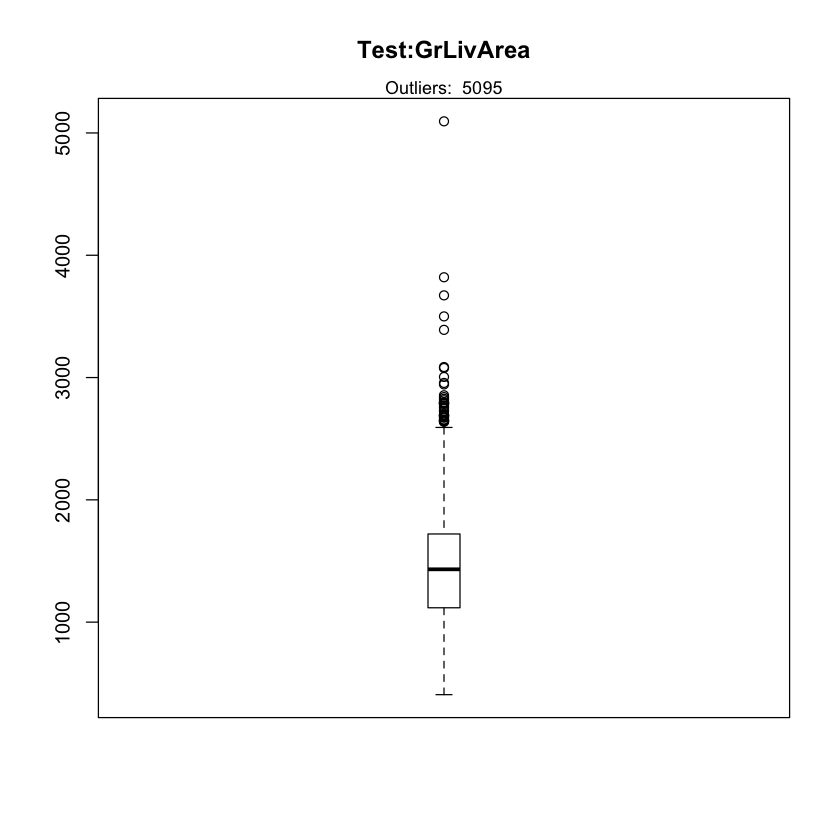

In [214]:
outlier_values <- boxplot.stats(house.price.test$GrLivArea)$out # outlier values.
boxplot(house.price.test$GrLivArea, main="Test:GrLivArea", boxwex=0.1)
mtext(paste("Outliers: ", paste(outlier_values[outlier_values>4000], collapse=", ")), cex=0.9)

In [215]:
id.outliers_tr <- which(house.price.train$GrLivArea > 4000)
id.outliers_ts <- which(house.price.test$GrLivArea > 4000)
house.price.train.cl <- house.price.train[!1:nrow(house.price.train) %in% id.outliers_tr,]

In [216]:
house.price.test.cl <- house.price.test[!1:nrow(house.price.test) %in% id.outliers_ts,]

In [217]:
str(house.price.train.cl)

'data.frame':	1456 obs. of  97 variables:
 $ MSSubClass        : int  60 20 60 70 60 50 20 60 50 190 ...
 $ MSZoning          : chr  "RL" "RL" "RL" "RL" ...
 $ LotFrontage       : num  65 80 68 60 84 ...
 $ LotArea           : int  8450 9600 11250 9550 14260 14115 10084 10382 6120 7420 ...
 $ Street            : chr  "Pave" "Pave" "Pave" "Pave" ...
 $ Alley             : chr  "None" "None" "None" "None" ...
 $ LotShape          : chr  "Reg" "Reg" "IR1" "IR1" ...
 $ LandContour       : chr  "Lvl" "Lvl" "Lvl" "Lvl" ...
 $ LotConfig         : chr  "Inside" "FR2" "Inside" "Corner" ...
 $ LandSlope         : chr  "Gtl" "Gtl" "Gtl" "Gtl" ...
 $ Neighborhood      : chr  "CollgCr" "Veenker" "CollgCr" "Crawfor" ...
 $ Condition1        : chr  "Norm" "Feedr" "Norm" "Norm" ...
 $ Condition2        : chr  "Norm" "Norm" "Norm" "Norm" ...
 $ BldgType          : chr  "1Fam" "1Fam" "1Fam" "1Fam" ...
 $ HouseStyle        : chr  "2Story" "1Story" "2Story" "2Story" ...
 $ OverallQual       : int  7 6 7 7

In [218]:
str(house.price.test.cl)

'data.frame':	1458 obs. of  96 variables:
 $ MSSubClass        : int  20 20 60 60 120 60 20 60 20 20 ...
 $ MSZoning          : chr  "RH" "RL" "RL" "RL" ...
 $ LotFrontage       : num  80 81 74 78 43 ...
 $ LotArea           : int  11622 14267 13830 9978 5005 10000 7980 8402 10176 8400 ...
 $ Street            : chr  "Pave" "Pave" "Pave" "Pave" ...
 $ Alley             : chr  "None" "None" "None" "None" ...
 $ LotShape          : chr  "Reg" "IR1" "IR1" "IR1" ...
 $ LandContour       : chr  "Lvl" "Lvl" "Lvl" "Lvl" ...
 $ LotConfig         : chr  "Inside" "Corner" "Inside" "Inside" ...
 $ LandSlope         : chr  "Gtl" "Gtl" "Gtl" "Gtl" ...
 $ Neighborhood      : chr  "NAmes" "NAmes" "Gilbert" "Gilbert" ...
 $ Condition1        : chr  "Feedr" "Norm" "Norm" "Norm" ...
 $ Condition2        : chr  "Norm" "Norm" "Norm" "Norm" ...
 $ BldgType          : chr  "1Fam" "1Fam" "1Fam" "1Fam" ...
 $ HouseStyle        : chr  "1Story" "1Story" "2Story" "2Story" ...
 $ OverallQual       : int  5 6 5 6 

In [219]:
write.csv(house.price.train.cl,file ='./data/train_cleanednewest.csv')

In [220]:
write.csv(house.price.test.cl,file ='./data/test_cleanednewest.csv')